In [1]:
#######################################################################
#
# lvm-dap-conf: main script to run the LVM-DAP
#
# 
# Notebook version of the lvm-dap-conf script. It runs using the same required inputs and configuration files.
# 
# It requires as inpunts: (1) a YAML file, (2) an input LVM-frame and (3) a label to define the output files
#
# (1) yaml_path = "lvm-dap_SD_fast_SN20_ofelia_nosky_hack_cl_few.yaml"
# (2) lvm_file = 'data_v1.1.1/lvmSFrame-00006109.fits'
# (3) label = 'dap-nb-00006109_few'
#
#
# The content and the format both the YAML and LVM-file should be the same as the ones
# used for the command-line script
#
#

In [80]:
###########################################################################
#
# Defining the environment settings and loading the required models
#
###########################################################################
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# Core Python libraries
import numpy as np
import yaml
from astropy.table import Table
from copy import deepcopy as copy
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from astropy.io import fits

# pyFIT3D and LVM DAP imports (assuming they are installed in your environment)
from lvmdap.pyFIT3D.common.io import clean_preview_results_files, print_time
from lvmdap.pyFIT3D.common.io import trim_waves
from lvmdap.dap_tools import (
    load_LVM_rss, load_LVMSIM_rss, load_in_rss,
    read_PT, read_MaStar_PT, read_LVMSIM_PT,
    read_tab_EL, find_redshift_spec,
    plot_spec_art, plot_spec, fit_legendre_polynomial,
    read_rsp, read_coeffs_RSP, read_elines_RSP, Table_mean_rows,
    replace_nan_inf_with_adjacent_avg, find_continuum, find_closest_indices,
    find_closest_indices_different, read_RSS_PT, get_DAP_tab
)
from lvmdap.flux_elines_tools import flux_elines_RSS_EW_cl
from lvmdap.dap_tools import sort_table_by_id
#from lvmdap.flux_elines_tools import flux_elines_RSS_EW_cl
#from lvmdap.modelling.auto_rsp_tools import auto_rsp_elines_rnd
from lvmdap._cmdline.dap import auto_rsp_elines_rnd
from lvmdap.dap_tools import nanaverage

from lvmdap.pyFIT3D.common.constants import __c__, __Ha_central_wl__, _MODELS_ELINE_PAR
from lvmdap.pyFIT3D.common.auto_ssp_tools import load_rss, dump_rss_output
from astropy.table import join as tab_join
from astropy.table import vstack as vstack_table
from lvmdap.pyFIT3D.common.gas_tools import kin_rss_elines_main

from lvmdap.pyFIT3D.common.io import array_to_fits, trim_waves, sel_waves, print_verbose, write_img_header

#from lvmdap.elines.kin_elines import kin_rss_elines_main, _MODELS_ELINE_PAR
#from lvmdap.dap_tools import trim_waves

In [72]:
def eline(w,W,F,D,V,dap_fwhm=2.354):
  c = 299792.00
  w0 = W*(1+(V/c))
  sigma=D/dap_fwhm
  e1=np.exp(-0.5*((w-w0)/sigma)**2)
  return F*e1/(sigma*((2*3.1416)**0.5))     

In [3]:
#from lvmdap.dap_tools import get_DAP_tab

In [4]:
###########################################################
#
#  Load config YAML file
#
###########################################################

# YAML for orion
#yaml_path = "lvm-dap_ORION_test_int.yaml"  # Update this if your file has a different name/path

# YAML for v1.1.1
yaml_path = "lvm-dap_SD_fast_SN20_ofelia_nosky_hack_cl.yaml"

# YAML for tests
#yaml_path = "lvm-dap_SD_fast_SN20_ofelia_nosky_hack_cl_few.yaml"


with open(yaml_path, 'r') as stream:
    config = yaml.safe_load(stream)

# Replace relative paths and pull all parameters into the namespace
lvmdap_dir = config.get("lvmdap_dir", ".")

keys = []
for key in config:
    keys.append(key)
keys = np.array(keys)

a_name=[]
a_value=[]




for key in keys:
    a_name.append(str(key))
    a_value.append(str(config[key]))
    if isinstance(config[key], str):
        config[key] = config[key].replace("..", lvmdap_dir)
    if (key.find("-")>-1):
        clean_key = key.replace("-", "_")
        value = config[key]
        config[clean_key] = value
#        del config[key]

tab_info=Table((a_name,a_value),names=('param','value'))
#hdu_info = fits.BinTableHDU(tab_info,name='INFO')

config["flux_scale"] = config["flux_scale_org"]    
    
config_items = [(k, v) for k, v in config.items()]
config_table = Table(rows=config_items, names=["param", "value"])
config_table.show_in_notebook()      



idx,param,value
0,output_path,/disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests
1,lvmdap_dir,/home/sanchez/sda2/code/python/lvmdap
2,rsp-file,/disk-a/sanchez/LVM/LVM/ver_231113/mstar-stlib-cl-108.fits.gz
3,sigma-inst,1
4,rsp-nl-file,/disk-a/sanchez/LVM/LVM/ver_231113/mstar-stlib-cl-12.fits.gz
5,input-fmt,rss
6,redshift,"[0.0, 5e-05, -0.0003, 0.0003]"
7,sigma,"[1, 5, 0.1, 30]"
8,AV,"[0, 0.3, 0.0, 2.5]"
9,emission-lines-file,/home/sanchez/sda2/code/python/lvmdap/_legacy/emission_lines_long_list.LVM


In [5]:
###########################################################
#                                                         #
#  Define input LVM-file and the output files' label      #
#                                                         #
###########################################################

#config["ny_range"] = (0,5)

# 1st data set
#lvm_file = "sel_1.1.0/sel-00020063.fits" #config["lvm_file"]

# 2nd data set
#lvm_file = "orion/sec-orion.fits"
lvm_file = "orion/sec-orion_all.fits"
label = "orion_10_nb" #config["label"]
#config["in_rss"] = True

# 3rd data set
#lvm_file = 'data_v1.1.1/lvmSFrame-00006109.fits'
#label = 'dap-nb-00006109'
#label = 'dap-nb-00006109_few'
config['label'] = label

# If you want to fit just a few spectra for testing
config["ny_range"] = (0,10)
tab_info.add_row(('ny-range',str(config["ny_range"])))

#

# We restrict the fitting to a very narrow range of spectra
#config["ny_range"] = ()
#0
#  - 10

In [6]:
tab_info.show_in_notebook()

idx,param,value
0,output_path,/disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests
1,lvmdap_dir,/home/sanchez/sda2/code/python/lvmdap
2,rsp-file,/disk-a/sanchez/LVM/LVM/ver_231113/mstar-stlib-cl-108.fits.gz
3,sigma-inst,1
4,rsp-nl-file,/disk-a/sanchez/LVM/LVM/ver_231113/mstar-stlib-cl-12.fits.gz
5,input-fmt,rss
6,redshift,"[0.0, 5e-05, -0.0003, 0.0003]"
7,sigma,"[1, 5, 0.1, 30]"
8,AV,"[0, 0.3, 0.0, 2.5]"
9,emission-lines-file,../_legacy/emission_lines_long_list.LVM


In [ ]:
os.chdir(config["lvmdap_dir"])

In [ ]:
######################################################################
#
#  Load the LVM-file 
#
######################################################################


# Choose input file
config["lvm_file"] = lvm_file 
config["label"] = label  
tab_info.add_row(('lvm-file',lvm_file))
tab_info.add_row(('label',label))

plot = int(config.get("plot", 0))
ny_range = config.get("ny_range", None)
nx_range = config.get("nx_range", None)

# Load spectrum
if config.get("lvmsim", False):
    wl, rss_flux, rss_eflux, hdr_flux, hdr_0 = load_LVMSIM_rss(lvm_file, ny_range=ny_range, nx_range=nx_range)
    pt_table = read_LVMSIM_PT(lvm_file, 'none', ny_range=ny_range)
elif config.get("in_rss", False):
    wl, rss_flux, rss_eflux, hdr_flux, hdr_0 = load_in_rss(lvm_file, ny_range=ny_range, nx_range=nx_range)
    try:
        pt_table = read_MaStar_PT(lvm_file, 'none', ny_range=ny_range)
    except:
        # Create placeholder PT table
        try:
            pt_table = read_RSS_PT(lvm_file, ny_range = ny_range)
        except:
            NL = rss_flux.shape[0]
            pt_table = Table()
            pt_table['id'] = np.arange(NL)
            pt_table['mask'] = np.full(NL, True)
else:
    wl, rss_flux, rss_eflux, hdr_flux, hdr_0 = load_LVM_rss(lvm_file, ny_range=ny_range, nx_range=nx_range, m2a=1)
    pt_table = read_PT(lvm_file, 'none', ny_range=ny_range)

#
# This should be included in the load_LVM_rss ??
#
try:
    hdu_LSF = fits.open(lvm_file)
    LSF_mean = np.nanmedian(hdu_LSF['LSF'].data,axis=0)/2.354
except:
    LSF_mean =  config['sigma_gas'] * np.ones(rss_flux.shape[1])
    
    

# Replace bad values
rss_flux = replace_nan_inf_with_adjacent_avg(rss_flux)
rss_eflux = replace_nan_inf_with_adjacent_avg(rss_eflux)
rss_eflux[rss_eflux == 0] = np.nanmedian(rss_eflux)

print(f"Loaded {rss_flux.shape[0]} spaxels.")


/home/sanchez/.local/lib/python3.8/site-packages/lvmdap/dap_tools.py:639: RuntimeWarning: divide by zero encountered in true_divide
  hdu_e = fits.ImageHDU(data=1/np.sqrt(rss_ivar),header=hdu[1].header,name='ERROR')


# sky re-evaluated
# sky-hack did not work
# Y-axis trimmed: (0, 10)
Loaded 10 spaxels.


In [8]:
##############################################################
#
# Apply mask to original data first
#
##############################################################

rss_flux_masked = rss_flux[pt_table['mask']]
rss_eflux_masked = rss_eflux[pt_table['mask']]
auto_z_min = config.get("auto_z_min", -0.003)
auto_z_max = config.get("auto_z_max", 0.005)

w0 = 6530 * (1 + auto_z_min)
w1 = 6650 * (1 + auto_z_max)
mask_line = (wl > w0) & (wl < w1)
# Recalculate SN_map using the masked data
SN_map_masked = np.array([
    np.nanmax(f[mask_line] / e[mask_line])
    for f, e in zip(rss_flux_masked, rss_eflux_masked)
])

# Apply S/N threshold
SN_threshold = 3
high_SN_mask = SN_map_masked > SN_threshold

# Compute the integrated flux based on S/N
if np.sum(high_SN_mask) < 3:
    int_flux = nanaverage(rss_flux_masked, 1 / rss_eflux_masked**2, axis=0)
else:
    int_flux = nanaverage(rss_flux_masked[high_SN_mask], 1 / rss_eflux_masked[high_SN_mask]**2, axis=0)

# Estimate the error in the integrated spectrum
int_eflux = np.sqrt(np.nanmedian(rss_eflux_masked**2, axis=0))


🔍 Estimating redshift from integrated spectrum...


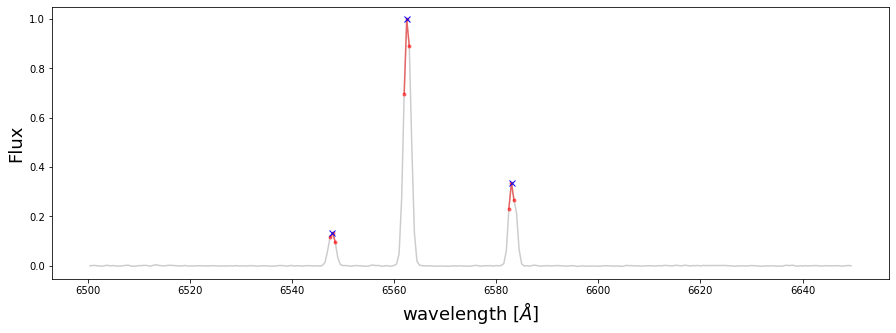

# f_peaks auto_redshift : [0.1322 0.9983 0.3367] using threshold: 0.1
Estimated redshift: -4.00000000002022e-05


In [9]:
###################################################
#
# Auto-detect the redshift of the spectra using Ha+[NII]
#
###################################################



auto_redshift = config.get("auto_redshift", False)
#
# force auto_redshift
#

#auto_redshift = True

#
# force plotting
#
plot = 1
%matplotlib inline

if auto_redshift:
    print("🔍 Estimating redshift from integrated spectrum...")
    int_flux_bg = find_continuum(int_flux, niter=15)
    int_flux_sub = int_flux - int_flux_bg
    z_auto = find_redshift_spec(
        wl, int_flux_sub, z_min=auto_z_min, z_max=auto_z_max,
        d_z=config.get("auto_z_d", 0.00001),
        w_min=6500, w_max=6650,
        w_ref=(6548.05, 6562.85, 6583.45),
        do_plot=plot
    )
    print(f"Estimated redshift: {z_auto}")
    config["redshift"][0] = z_auto


In [10]:
###########################################
#
# Prepare output file names
#
###########################################

output_dir = config["output_path"]
os.makedirs(output_dir, exist_ok=True)

prefix = f"{output_dir}/m_{config['label']}"

out_files = {
    "elines": f"{prefix}.elines.txt",
    "single": f"{prefix}.single.txt",
    "coeffs": f"{prefix}.coeffs.txt",
    "fit": f"{prefix}.output.fits",
    "rsp": f"{prefix}.rsp.txt",
    "fe": f"{prefix}.fe.ecsv",
    "pt": f"{prefix}.PT.ecsv"
}

# Optionally clear previous output
if config.get("clear_outputs", False):
    for f in out_files.values():
        try:
            os.remove(f)
            print(f"🗑️ Removed old file: {f}")
        except FileNotFoundError:
            pass


🗑️ Removed old file: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_orion_10_nb.elines.txt
🗑️ Removed old file: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_orion_10_nb.coeffs.txt
🗑️ Removed old file: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_orion_10_nb.output.fits
🗑️ Removed old file: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_orion_10_nb.rsp.txt
🗑️ Removed old file: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_orion_10_nb.fe.ecsv
🗑️ Removed old file: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_orion_10_nb.PT.ecsv


In [11]:
#########################################################
#
# Fitting the integrated spectra with a combination of RSPs
# and a set of emission lnes (Gaussian Functions)
#
#########################################################


print("🚀 Fitting integrated spectrum...")

# Force plotting 0/1
#plot = 1
plot = 0
%matplotlib inline


if ((config["flux_scale"][0]==-1) and (config["flux_scale"][1]==1)):
      config["flux_scale"][0]=-0.1*np.abs(np.median(int_flux))
      config["flux_scale"][1]=3*np.abs(np.median(int_flux))+10*np.std(int_flux)
      

cf, SPS = auto_rsp_elines_rnd(
    wl__w=wl, f__w=int_flux, ef__w=int_eflux,
    ssp_file=config["rsp_file"],
    ssp_nl_fit_file=config["rsp_nl_file"],
    sigma_inst=config["sigma_inst"],
    spaxel_id=label,
    config_file=config.get("config_file"),
    elines_mask_file=config.get("emission_lines_file"),
    mask_list=config.get("mask_file"),
    fit_gas=not config.get("ignore_gas", False),
    refine_gas=not config.get("single_gas_fit", False),
    sigma_gas=config.get("sigma_gas", 3.0),
    input_redshift=config["redshift"][0],
    delta_redshift=config["redshift"][1],
    min_redshift=config["redshift"][2],
    max_redshift=config["redshift"][3],
    input_sigma=config["sigma"][0],
    delta_sigma=config["sigma"][1],
    min_sigma=config["sigma"][2],
    max_sigma=config["sigma"][3],
    input_AV=config["AV"][0],
    delta_AV=config["AV"][1],
    min_AV=config["AV"][2],
    max_AV=config["AV"][3],
    w_min=config["w_range"][0],
    w_max=config["w_range"][1],
    nl_w_min=config["w_range_nl"][0],
    nl_w_max=config["w_range_nl"][1],
    min=config["flux_scale"][0],
    max=config["flux_scale"][1],
    out_path=config["output_path"],
    plot=plot
)


🚀 Fitting integrated spectrum...
# Using predefined configuration file for the emission lines
##############################
# START: fitting the continuum+emission lines, fit_gas:True ...
-> median error in flux = 495.2190
-> median error in flux = 495.2190
-> median raw flux = 96.5254 - Warning: no cut (CUT_MEDIAN_FLUX = 0)
Normalization window = [5454.779999999999, 5544.779999999999]
Signal-to-Noise inside normalization window = 1.4208867238955405
-> MED_FLUX : 358.87535057416335 +- 514.7388233685647 SN:1.4208867238955405
-> Single SSP fit 
- Redshift: -0.00004000 +- 0.00000000
- Sigma:    1.00000000 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0073 |        0.0075 |
------------

In [12]:
#############################################################################
#  
# Saving the output files of the RSP+EL analysis for the integrated spectrum
#
#############################################################################


output_path = config["output_path"]
os.makedirs(output_path, exist_ok=True)

SPS.output_gas_emission(filename=f"{output_path}/m_{label}.elines.txt")
SPS.output_coeffs_MC(filename=f"{output_path}/m_{label}.coeffs.txt")
SPS.output_fits(filename=f"{output_path}/m_{label}.output.fits")
SPS.output(filename=f"{output_path}/m_{label}.rsp.txt")

print("✅ Integrated spectrum fitting complete and results saved.")



6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_orion_10_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_orion_10_nb.elines.txt
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_orion_10_nb.elines.txt
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_orion_10_nb.elines.txt
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_orion_10_nb.elines.txt
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_orion_10_nb.elines.txt
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_orion_10_nb.elines.txt
9069-9069 wav

# S/N: 0.11896979097609305 211.06438422296102 1774.1006560680128
# mean_val_ssp : 3.833429734349522e-18


/home/sanchez/.local/lib/python3.8/site-packages/lvmdap/dap_tools.py:2408: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


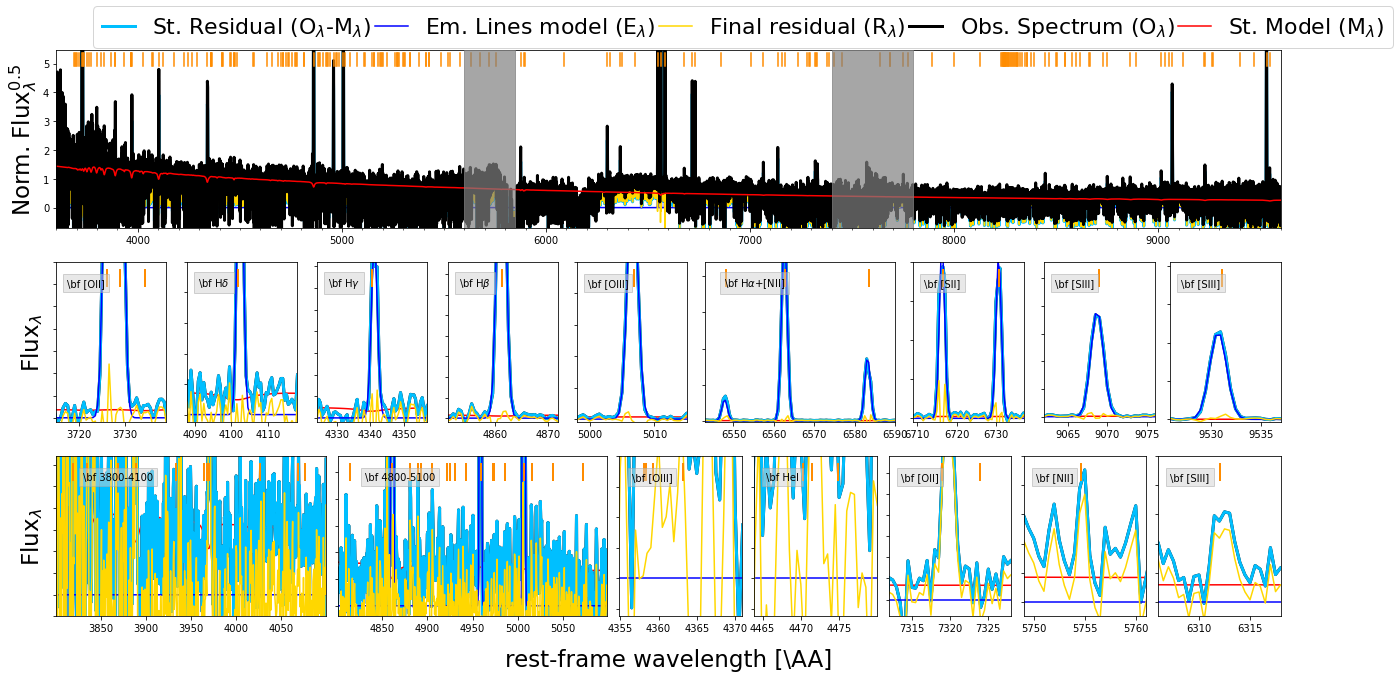

In [ ]:
#############################################################################
#  
# Plotting the results of the fitting of the integarted spectrum RSP+EL
#
#############################################################################
%matplotlib inline
if config.get("do_plots", 0) == 1:
    tab_el = read_tab_EL(config["emission_lines_file_long"])
    y_off = -1.09
    y_off2 = -2.18
    plot_spec_art(dir='',
                  file=out_files["fit"],
                  file_ssp=out_files["rsp"],
                  name=config["label"],
                  output=f"{output_dir}/plot_m_{config['label']}.pdf",
                  c_map='CMRmap',\
                  insets=((0.00, y_off, 0.09, 0.9,3715,3739,-1,35,'[OII]'),\
                          (0.107, y_off, 0.09, 0.9,4088,4118,-0.5,10,r'H$\delta$'),\
                          (0.213, y_off, 0.09, 0.9,4324,4357,-0.5,18,r'H$\gamma$'),\
                          (0.320, y_off, 0.09, 0.9,4851,4872,-1.0,38,r'H$\beta$'),\
                          (0.425, y_off, 0.09, 0.9,4998,5015,-1.0,50,'[OIII]'),\
                          (0.530, y_off, 0.155, 0.9,6543,6590,-2,220,r'H$\alpha$+[NII]'),\
                          (0.700, y_off, 0.09, 0.9,6709,6737,-0.5,20,'[SII]'),\
                          (0.807, y_off, 0.09, 0.9,9062,9076,-1.0,28,'[SIII]'),\
                          (0.910, y_off, 0.09, 0.9,9526,9537,-1.5,82,'[SIII]'),\
                          (0.00, y_off2, 0.22, 0.9,3801,4099,-0.5,3.2,'3800-4100'),\
                          (0.23, y_off2, 0.22, 0.9,4801,5099,-0.2,2.8,'4800-5100'),\
                          (0.46, y_off2, 0.10, 0.9,4363-8.1,4363+7.9,-0.25,0.8,'[OIII]'),\
                          (0.57, y_off2, 0.10, 0.9,4472-8.1,4472+7.9,-0.25,0.8,'HeI'),\
                          (0.68, y_off2, 0.10, 0.9,7320-8,7320+8,-0.2,1.7,'[OII]'),\
                          (0.79, y_off2, 0.10, 0.9,5755-6,5755+6,-0.25,2.5,'[NII]'),\
                          (0.90, y_off2, 0.10, 0.9,6312-6,6312+6,-0.25,2.5,'[SIII]')
                         ),
                      y_min=-0.5,y_max=30,y0_d=0.3,y1_d=2.9,\
                      x_min=3600,x_max=9600,plot_el=True, tab_el=tab_el,plot_res=True,\
                      show_scale=False,n_ord=2,gamma=0.5)#,x_min=3600,x_max=9600)



In [14]:
######################################################################
#
# Non-parametric analysis of the emission lines for the RSP-subtracted
# integrated spectrum (gas-pure spectrum)
#
######################################################################

# Prepare model outputs
%matplotlib notebook
#config["do_plots"]=1
config["do_plots"]=1
config["plot"]=1
plot = 1
do_plots = 1

#%matplotlib inline

out_model = np.array(SPS.output_spectra_list)
gas = out_model[0] - out_model[1]
smooth = median_filter(gas, size=config.get("smooth_size", 21))
l_smooth = fit_legendre_polynomial(wl, smooth, config.get("n_leg", 51))

out_model[2] += l_smooth
out_model[3] = out_model[0] - (out_model[1] + l_smooth)
out_model[4] = out_model[0] - out_model[2]

# Prepare single-RSS input for flux_elines
m_flux_rss = np.expand_dims(out_model[0] - out_model[1] - l_smooth, axis=0)
m_e_flux_rss = np.expand_dims(int_eflux, axis=0)
m_s_flux_rss = np.expand_dims(out_model[1] + l_smooth, axis=0)

vel__yx = np.zeros(1) + config["redshift"][0] * __c__
sigma__yx = config.get("sigma_gas", 0.8)
sigma__yx = 0.86
# Read emission lines again
tab_el = read_tab_EL(config["emission_lines_file_long"])

#
# We find the nearest emission line
#
lsf = []
blended = []
for wl_el in tab_el['wl']:
    i_wl_el = find_closest_indices(wl, wl_el)
    lsf_now = LSF_mean[i_wl_el[0]]
    lsf.append(lsf_now)
    i_wl_near = find_closest_indices_different(tab_el['wl'], wl_el)
    dist_abs = np.abs(wl_el-tab_el['wl'][i_wl_near[0]])
    if (dist_abs<4*sigma__yx):
        blended.append(1)
    else:
        blended.append(0)
blended = np.array(blended)    
tab_el['blended'] = blended
lsf = np.array(lsf)
tab_el['lsf'] = lsf
sigma_we = 1.0

#tab_el['lsf'] = 0.86
#print(np.sqrt(tab_el['lsf']**2+sigma__yx**2))

#tab_el['lsf'] = None
#sigma_we = 0.5

# Run flux_elines
fe_data, fe_hdr = flux_elines_RSS_EW_cl(
    m_flux_rss, hdr_flux, 5, tab_el, vel__yx, sigma__yx,
    eflux__wyx=m_e_flux_rss, flux_ssp__wyx=m_s_flux_rss,
    w_range=config.get("w_range_FE", 30),
    plot=config.get("do_plots", 0), sigma_we = sigma_we
)

# Convert to Astropy Table and save
colnames = [f"{fe_hdr[f'NAME{i}']}_{fe_hdr[f'WAVE{i}']}".replace(" ", "_") for i in range(fe_data.shape[0])]
tab_fe = Table(np.transpose(fe_data), names=colnames)
tab_fe.write(out_files["fe"], overwrite=True, delimiter=',')
print(f"📊 Emission line table saved to: {out_files['fe']}")



1 12401 1
215 emission lines
0 HI 3686.83
1 HI 3691.56
2 HI 3697.15
3 HI 3703.85
4 HI 3711.97
5 [OII] 3726.03
6 [OII] 3728.82
7 HI 3734.37
8 HI 3750.15
9 [FeVII] 3758.9
10 HI 3770.63
11 HI 3797.9
12 HeI 3819.61
13 HI 3835.38
14 [NeIII] 3868.75
15 HeI 3888.65
16 HI 3889.05
17 CaII 3933.66
18 HeI 3964.73
19 [NeIII] 3967.46
20 CaII 3968.47
21 Hepsilon 3970.07
22 HeI 4026.19
23 [SII] 4068.6
24 [SII] 4076.35
25 Hdelta 4101.77
26 HeI 4120.81
27 [FeII] 4177.21
28 [FeV] 4227.2
29 [FeII] 4243.98
30 CII 4267.0
31 [FeII] 4287.4
32 Hgamma 4340.49
33 [FeII] 4358.1
34 [FeII] 4358.37
35 [FeII] 4359.34
36 [OIII] 4363.21
37 [FeII] 4413.78
38 [FeII] 4414.45
39 [FeII] 4416.27
40 [FeII] 4452.11
41 [FeII] 4457.95
42 [FeII] 4470.29
43 HeI 4471.48
44 [FeII] 4474.91
45 [NiII] 4485.21
46 [MgI] 4562.48
47 MgI] 4571.1
48 [FeII] 4632.27
49 [FeIII] 4658.1
50 HeII 4685.68
51 [FeIII] 4701.62
52 [ArIV] 4711.33
53 HeI 4713.14
54 [NeIV] 4724.17
55 [FeIII] 4733.93
56 [ArIV] 4740.2
57 [FeIII] 4754.83
58 [FeIII] 4769.6
59

<IPython.core.display.Javascript object>

📊 Emission line table saved to: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_orion_10_nb.fe.ecsv


In [15]:
#######################################################
#
# We remove the option to plot all figures
#
#######################################################
config["do_plot"] = 0
config["plot"] = 0


In [ ]:
###########################################################
#
# Starting full RSS fitting for all spaxels
#
###########################################################


print("🚀 Starting full RSS fitting for all spaxels...\n")

out_file_fe = os.path.join(config["output_path"], f"{label}.fe.txt")
out_file_elines = os.path.join(config["output_path"], f"{label}.elines.txt")
out_file_kel = os.path.join(config["output_path"], f"{label}.kel.txt")
out_file_single = os.path.join(config["output_path"], f"{label}.single.txt")
out_file_coeffs = os.path.join(config["output_path"], f"{label}.coeffs.txt")
out_file_fit = os.path.join(config["output_path"], f"{label}.output.fits.gz")
out_file_ps = os.path.join(config["output_path"], f"{label}.rsp.txt")
out_file_dap = os.path.join(config["output_path"], f"{label}.dap.fits.gz")

# remove previous outputs with the same label
if (config["clear_outputs"]):
    clean_preview_results_files(out_file_ps, out_file_elines, out_file_single, out_file_coeffs, out_file_fit)
    clean_preview_results_files(out_file_fe, out_file_elines, out_file_single, out_file_coeffs, out_file_fit)
    clean_preview_results_files(out_file_dap, out_file_elines, out_file_single, out_file_coeffs, out_file_fit)
    clean_preview_results_files(out_file_kel, out_file_elines, out_file_single, out_file_coeffs, out_file_fit)



rss_flux_masked = rss_flux[pt_table['mask']]
rss_eflux_masked = rss_eflux[pt_table['mask']]
tab_PT_masked = pt_table[pt_table['mask']]
tab_PT = tab_PT_masked 

model_spectra = []
y_ratio = None
nspec = rss_flux_masked.shape[0]

# Reuse the SPS from integrated spectrum as starting point
SPS_master = SPS

for i, (f__w, ef__w) in enumerate(zip(rss_flux_masked, rss_eflux_masked)):
    print(f"\n### Fitting spaxel {i+1}/{nspec} (ID: {tab_PT_masked['id'][i]})")

    #
    # printing some values
    #
    # print(SPS.best_redshift)
    # print(SPS.best_sigma)
    # print(SPS.best_AV)

    cf = SPS.config
    cf.redshift = SPS.best_redshift
    cf.sigma = SPS.best_sigma
    cf.AV = SPS.best_AV
    spaxel_label = f"{config['label']}_{i}"
    
    _, SPS = auto_rsp_elines_rnd(
        wl__w=wl, f__w=f__w, ef__w=ef__w,
        ssp_file=config["rsp_file"],
        ssp_nl_fit_file=config["rsp_nl_file"],
        config_file=config["config_file"],
        w_min=config["w_range"][0], w_max=config["w_range"][1],
        nl_w_min=config["w_range_nl"][0], nl_w_max=config["w_range_nl"][1],
        mask_list=config.get("mask_file"),
        min=config["flux_scale"][0], max=config["flux_scale"][1],
        elines_mask_file=config.get("emission_lines_file"),
        fit_gas=not config.get("ignore_gas", False),
        refine_gas=not config.get("single_gas_fit", False),
        sigma_gas=config.get("sigma_gas", 3.0),
        input_redshift=config["redshift"][0],
        delta_redshift=config["redshift"][1],
        min_redshift=config["redshift"][2],
        max_redshift=config["redshift"][3],
        input_sigma=config["sigma"][0],
        delta_sigma=config["sigma"][1],
        min_sigma=config["sigma"][2],
        max_sigma=config["sigma"][3],
        input_AV=config["AV"][0],
        delta_AV=config["AV"][1],
        min_AV=config["AV"][2],
        max_AV=config["AV"][3],
        sigma_inst=config["sigma_inst"],
        spaxel_id=spaxel_label,
        out_path=config["output_path"],
        plot=config.get("plot", 0),
        SPS_master=SPS_master,
        SN_CUT=config.get("SN_CUT", 3)
    )

    SPS.output_gas_emission(filename=f"{output_dir}/{config['label']}.elines.txt", spec_id=i)
    SPS.output_coeffs_MC(filename=f"{output_dir}/{config['label']}.coeffs.txt", write_header=(i == 0))

    try:
        SPS.output(filename=f"{output_dir}/{config['label']}.rsp.txt", write_header=(i == 0), block_plot=False)
    except Exception as e:
        print(f"⚠️ Warning: Failed to write spaxel {i} summary output. Filling with NaNs.")
        pass

    model_spectra.append(SPS.output_spectra_list)


🚀 Starting full RSS fitting for all spaxels...


### Fitting spaxel 1/8 (ID: 6560.3)
# Using predefined configuration file for the emission lines
##############################
# START: fitting the continuum+emission lines, fit_gas:True ...
-> median error in flux = 501.9715
-> median raw flux = 106.6940 - Warning: no cut (CUT_MEDIAN_FLUX = 0)
Normalization window = [5454.779999999999, 5544.779999999999]
Signal-to-Noise inside normalization window = 1.0118158106057342
-> MED_FLUX : 592.49853515625 +- 931.4092039292973 SN:1.0118158106057342
-> Single SSP fit 
- Redshift: -0.00004000 +- 0.00000000
- Sigma:    1.00000000 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0075 |        0.0081

In [ ]:
############################################################
#
# Re-arrage the output models for storing them into a file
#
############################################################


# Convert list of model_spectra into a single array
model_spectra = np.array(model_spectra).transpose(1, 0, 2)  # shape: [components, spaxels, wavelength]

# Decompose into useful pieces (gas model, smooth continuum, residuals, etc.)
gas_spectra = model_spectra[0] - model_spectra[1]
l_smooth_spectra = np.zeros_like(gas_spectra)

for idx, gas in enumerate(gas_spectra):
    smooth = median_filter(gas, size=config.get("smooth_size", 21))
    l_smooth = fit_legendre_polynomial(wl, smooth, config.get("n_leg", 51))
    l_smooth_spectra[idx] = l_smooth

# Update model_spectra with refined components
model_spectra[2] += l_smooth_spectra
model_spectra[3] = model_spectra[0] - (model_spectra[1] + l_smooth_spectra)
model_spectra[4] = model_spectra[0] - model_spectra[2]


In [71]:
######################################
#
# model_spectra.shape
#

model_spectra.shape

(6, 8, 12401)

In [ ]:
######################################################
#
# Writting the final model!
#
######################################################

# Final output cube (.fits.gz)
final_fit_filename = f"{output_dir}/{config['label']}.output.fits.gz"



#dump_rss_output(
#    out_file_fit=final_fit_filename,
#    wavelength=wl,
#    model_spectra=model_spectra
#)

#print(f"📦 Full data cube saved to: {final_fit_filename}")


📦 Full data cube saved to: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/orion_10_nb.output.fits.gz


In [20]:
#####################################################
#
# Read the products of the analysis into astropy Tables
#
#####################################################

tab_rsp = read_rsp(file_ssp = out_file_ps)
tab_coeffs = read_coeffs_RSP(coeffs_file= out_file_coeffs)
tab_elines = read_elines_RSP(elines_file= out_file_elines)
tab_elines["id"] = [tab_PT_masked["id"][fib] for fib in tab_elines["id_fib"]]

# Compute and save mean PT table


tab_PT_mean = Table_mean_rows(tab_PT_masked)
tab_PT_mean["fiberid"] = [config["label"]]
tab_PT_mean.write(out_files["pt"], overwrite=True)

print("✅ All spaxels fitted and outputs generated.")

✅ All spaxels fitted and outputs generated.


In [21]:
#####################################################
#
# Re-orde the Parametric Emission line dataproducts
# into a table in which each row corresponds to a
# fiber
#
#####################################################


# Filter only "eline" entries
mask_elines = tab_elines["model"] == "eline"
tab_elines = tab_elines[mask_elines]
#tab_elines["id"] = tab_elines["id_fib"]
# Extract all unique emission line wavelengths
a_wl = np.unique(tab_elines["wl"])

# Organize the emission line measurements into a wide table
tab_PE_ord = Table()
tab_PE_ord["id"] = tab_PT["id"]  # <-- Fixed here
#print(tab_PE_ord["id"])
for wl_now in a_wl:
    if wl_now > 0.0:
        tab_PE_now = tab_elines[tab_elines["wl"] == wl_now]
        tab_PE_tmp = tab_PE_now["id", "flux", "e_flux", "disp", "e_disp", "vel", "e_vel"]
        tab_PE_tmp
        for col in tab_PE_tmp.colnames:
            if col != "id":
                tab_PE_tmp.rename_column(col, f"{col}_{wl_now}")
#        print(tab_PE_tmp['id'])
        tab_PE_ord = tab_join(tab_PE_ord, tab_PE_tmp, keys=["id"], join_type="left")
        #print(tab_PE_ord["id"])
tab_PE_ord = sort_table_by_id(tab_PE_ord,tab_PT)


In [22]:
########################################################
#
# Extracting the velocity from the emission lines closest
# to Halpha
#
########################################################

# Identify closest match to H-alpha central wavelength
w_Ha = a_wl.flat[np.abs(a_wl - 6562.68).argmin()]

vel_mean = np.nanmean(tab_PE_ord[f"vel_{w_Ha}"])
disp_mean = np.nanmean(tab_PE_ord[f"disp_{w_Ha}"])

# Initialize kinematic maps (for guided eline fitting)
vel__yx_val = np.full(hdr_flux["NAXIS2"], vel_mean)
sigma__yx_val = disp_mean


print(f"# ELINES Ha kinematics parameters:")
print(f"# vel_mean: {vel_mean:.2f} km/s")
print(f"# disp_mean: {disp_mean:.2f} km/s")


# ELINES Ha kinematics parameters:
# vel_mean: -10.08 km/s
# disp_mean: 0.70 km/s


In [ ]:
#####################################################
#
# Perform the Non-Parametric analysis of the emission lines
#
#####################################################

# Prepare clean gas spectrum = (obs - stellar model - smooth residual)
gas_clean = model_spectra[0] - model_spectra[1] - l_smooth_spectra

# Emission line analysis input parameters
# tab_el = read_tab_EL(config["emission_lines_file_long"])
vel__yx = np.ones(gas_clean.shape[0]) * vel_mean
sigma__yx = np.ones(gas_clean.shape[0]) * disp_mean



#
# This is the velocity guess in the Command-Line tool:
#
for I,val in enumerate(tab_PE_ord[f'vel_{w_Ha}'].value):
    if (np.isfinite(val)==True):
        try:
            vel__yx[I]=val
        except:
            vel__yx[I]=vel_mean
    else:
        vel__yx[I] = vel_mean


        
        
print(f"🔬 Running emission line flux measurement on all spaxels...")

config["do_plots"] = 0

# Run emission line fitting on full RSS
fe_data, fe_hdr = flux_elines_RSS_EW_cl(
    gas_clean,
    hdr_flux,
    5,
    tab_el,
    vel__yx,
    sigma__yx,
    eflux__wyx=rss_eflux_masked,
    flux_ssp__wyx=model_spectra[1],
    w_range=config.get("w_range_FE", 30),
    verbose=False,
    sigma_we = 0.9,
    plot=config.get("do_plots", 0)
)



🔬 Running emission line flux measurement on all spaxels...
8 12401 0
215 emission lines
0 HI 3686.83
1 HI 3691.56
2 HI 3697.15
3 HI 3703.85
4 HI 3711.97
5 [OII] 3726.03
6 [OII] 3728.82
7 HI 3734.37
8 HI 3750.15
9 [FeVII] 3758.9
10 HI 3770.63
11 HI 3797.9
12 HeI 3819.61
13 HI 3835.38
14 [NeIII] 3868.75
15 HeI 3888.65
16 HI 3889.05
17 CaII 3933.66
18 HeI 3964.73
19 [NeIII] 3967.46
20 CaII 3968.47
21 Hepsilon 3970.07
22 HeI 4026.19
23 [SII] 4068.6
24 [SII] 4076.35
25 Hdelta 4101.77
26 HeI 4120.81
27 [FeII] 4177.21
28 [FeV] 4227.2
29 [FeII] 4243.98
30 CII 4267.0
31 [FeII] 4287.4
32 Hgamma 4340.49
33 [FeII] 4358.1
34 [FeII] 4358.37
35 [FeII] 4359.34
36 [OIII] 4363.21
37 [FeII] 4413.78
38 [FeII] 4414.45
39 [FeII] 4416.27
40 [FeII] 4452.11
41 [FeII] 4457.95
42 [FeII] 4470.29
43 HeI 4471.48
44 [FeII] 4474.91
45 [NiII] 4485.21
46 [MgI] 4562.48
47 MgI] 4571.1
48 [FeII] 4632.27
49 [FeIII] 4658.1
50 HeII 4685.68
51 [FeIII] 4701.62
52 [ArIV] 4711.33
53 HeI 4713.14
54 [NeIV] 4724.17
55 [FeIII] 4733.

In [24]:
#####################################################
#
# Convert NP emission line data into an astropy Table
#
#####################################################

# Convert emission line data into an astropy Table
colnames = [
    f"{fe_hdr[f'NAME{i}']}_{fe_hdr[f'WAVE{i}']}".replace(" ", "_")
    for i in range(fe_data.shape[0])
]
tab_fe = Table(np.transpose(fe_data), names=colnames)

# Save to file
fe_output_path = f"{output_dir}/{config['label']}.fe.ecsv"
tab_fe.write(fe_output_path, overwrite=True, delimiter=',')

print(f"📊 Emission line table saved to: {fe_output_path}")

📊 Emission line table saved to: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/orion_10_nb.fe.ecsv


In [ ]:
#####################################################
#
# START: KIN_ELINES analysis on full RSS spectra ###
# 2nd parametric analysis of the emission lines 
# stored in the KEL  extension
#
#####################################################


print("#####################################################")
print("# START: KIN_ELINES analysis on full RSS spectra ###")
print("#####################################################")

cf = SPS.config  # Extract RSP config (contains systems_config)

# Use non-parametric emission line maps as guide
vel_map = np.array(tab_fe[f'vel_Halpha_{w_Ha}'])
sigma_map = np.array(tab_fe[f'disp_Halpha_{w_Ha}'])

# Kinematic parameter ranges
vel_mean = np.nanmean(vel_map)
vel_hr = 3 * np.nanstd(vel_map)
vel_min = vel_mean - vel_hr
vel_max = vel_mean + vel_hr

disp_mean = np.nanmean(sigma_map)
disp_sigma = np.nanstd(sigma_map)

# Optional fixed parameters (usually left None)
vel_fixed = None
sigma_fixed = None
vel_mask_map = None

# Output file for kinematic eline results
#out_file_kel = f"{output_dir}/{config['label']}.kel.txt"

# Guided emission-line fitting for each kinematic system
for i_s in range(cf.n_systems):
    syst = cf.systems[i_s]
    elcf = cf.systems_config[i_s]

    z_fact = 1 + vel_mean / __c__
    w_min, w_max = syst["start_w"], syst["end_w"]
    w_min_corr = int(w_min * z_fact)
    w_max_corr = int(w_max * z_fact)

    sel_wl_range = trim_waves(wl, [w_min_corr, w_max_corr])

    # Configure fit limits for v0 and sigma
    elcf.guess[0][_MODELS_ELINE_PAR['v0']] = vel_mean
    elcf.to_fit[0][_MODELS_ELINE_PAR['v0']] = 1
    elcf.pars_0[0][_MODELS_ELINE_PAR['v0']] = vel_min
    elcf.pars_1[0][_MODELS_ELINE_PAR['v0']] = vel_max
    elcf.links[0][_MODELS_ELINE_PAR['v0']] = -1

    elcf.guess[0][_MODELS_ELINE_PAR['sigma']] = disp_mean
    elcf.to_fit[0][_MODELS_ELINE_PAR['sigma']] = 1
    elcf.pars_0[0][_MODELS_ELINE_PAR['sigma']] = disp_mean - 1.5 * disp_sigma - 0.2 * disp_mean
    elcf.pars_1[0][_MODELS_ELINE_PAR['sigma']] = disp_mean + 1.5 * disp_sigma + 0.2 * disp_mean
    elcf.links[0][_MODELS_ELINE_PAR['sigma']] = -1

    # Slice flux and error arrays for this wavelength range
    gas_spectra = model_spectra[0] - model_spectra[1] - l_smooth_spectra
    sec_flux = gas_spectra.T[sel_wl_range].T
    sec_eflux = rss_eflux.T[sel_wl_range].T

    print(f"# Analyzing {elcf.n_models} model(s) in {w_min}-{w_max} Å window")

    # Run guided Gaussian fitting
    kin_rss_elines_main(
        wl[sel_wl_range],
        sec_flux,
        elcf,
        out_file=out_file_kel,
        rss_eflux=sec_eflux,
        run_mode='BOTH',
        guided=True,
        memo=False,
        vel_map=vel_map,
        vel_mask_map=vel_mask_map,
        vel_fixed=vel_fixed,
        sigma_map=sigma_map,
        sigma_fixed=sigma_fixed,
        n_MC=config.get("N_MC", 50),
        n_loops=config.get("n_loops", 3),
        scale_ini=0.15,
        fine_search=None,
        redefine_max=False,
        max_factor=2,
        redefine_min=False,
        min_factor=0.012,
        plot=config.get("plot", 0)
    )
# Load kinematic elines results
tab_kel = read_elines_RSP(elines_file=out_file_kel)

# Attach fiber ID using pt_table

id_kel = [tab_PT["id"].value[id_fib] for id_fib in tab_kel["id_fib"]]
tab_kel.add_column(np.array(id_kel), name="id", index=0)

print("#####################################################")
print("# END: KIN_ELINES analysis on full RSS spectra ###")
print("#####################################################")


#####################################################
# START: KIN_ELINES analysis on full RSS spectra ###
#####################################################
# Analyzing 3 model(s) in 6510-6620 Å window
# ID 0/7
guided...
guided disp...
-> real number of loops = 156
-> number of models = 3 | chi^2 = 0.5316403982150116
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 147138.0878 +/- 810.7104 |    0.6738 +/-  0.0046 |   -9.2733 +/-  0.0558 |
| eline | 6583.4500 +/-  0.0000 | 50618.6131 +/- 563.4663 |    0.6738 +/-  0.0046 |   -9.2733 +/-  0.0558 |
| eline | 6548.0500 +/-  0.0000 | 16855.9982 +/- 521.8929 |    0.6738 +/-  0.0046 |   -9.2733 +/-  0.0558 |
-------------------------

In [26]:
#####################################################################
# 
# Preparing the KEL table to be stored
#
#####################################################################

tab_kel = read_elines_RSP(elines_file=out_file_kel)
id_kel = [tab_PT["id"].value[id_fib] for id_fib in tab_kel["id_fib"]]
tab_kel.add_column(np.array(id_kel), name="id", index=0)
tab_kel

id,id_fib,model,wl,flux,e_flux,disp,e_disp,vel,e_vel
str7,int64,str11,float64,float64,float64,float64,float64,float64,float64
6560.3,0,eline,6562.85,147138.0878,810.7104,0.6738,0.0046,-9.2733,0.0558
6560.3,0,eline,6583.45,50618.6131,563.4663,0.6738,0.0046,-9.2733,0.0558
6560.3,0,eline,6548.05,16855.9982,521.8929,0.6738,0.0046,-9.2733,0.0558
6560.4,1,eline,6562.85,133855.0594,791.0919,0.6832,0.0,-9.4268,0.11
6560.4,1,eline,6583.45,53923.6475,735.9158,0.6832,0.0,-9.4268,0.11
6560.4,1,eline,6548.05,17956.5746,693.8696,0.6832,0.0,-9.4268,0.11
6560.5,2,eline,6562.85,119892.2524,1136.5481,0.6501,0.0,-8.7969,0.1828
6560.5,2,eline,6583.45,46786.5642,1102.7117,0.6501,0.0,-8.7969,0.1828
6560.5,2,eline,6548.05,15579.9259,843.5915,0.6501,0.0,-8.7969,0.1828


In [27]:
#####################################################################
#
# Separate the results from the non-paramectric emission line analysis
# into the different arms of the spectrograph to store them as
# fits-tables (fits-tables have a limit of 999 columns!)
#
#####################################################################


# Build column names and classify by wavelength region
colnames, colnames_B, colnames_R, colnames_I = [], [], [], []

for i in range(fe_data.shape[0]):
    wave = float(fe_hdr[f"WAVE{i}"])
    name = f"{fe_hdr[f'NAME{i}']}_{wave}".replace(" ", "_")
    colnames.append(name)
    if wave < 5755:
        colnames_B.append(name)
    elif wave < 7545:
        colnames_R.append(name)
    else:
        colnames_I.append(name)

tab_fe = Table(np.transpose(fe_data), names=colnames)
tab_fe_B = tab_fe[colnames_B]
tab_fe_R = tab_fe[colnames_R]
tab_fe_I = tab_fe[colnames_I]


In [28]:
######################################################
# 
# Just a patch of the id entry in the tables
# TBD: Not sure if it is needed actually
#
######################################################

try:
    tab_rsp.remove_column("id")
    tab_fe.remove_column("id")
    tab_fe_B.remove_column("id")
    tab_fe_R.remove_column("id")
    tab_fe_I.remove_column("id")
    tab_coeffs.remove_column("id")
except:
    print('No id in tables')


No id in tables


In [29]:
np.array(list(config.keys()))

array(['output_path', 'lvmdap_dir', 'rsp-file', 'sigma-inst', 'rsp-nl-file', 'input-fmt', 'redshift', 'sigma', 'AV', 'emission-lines-file', 'emission-lines-file-long', 'emission-lines-file-sky',
       'w-range', 'mask-file', 'config-file', 'clear_outputs', 'w-range-nl', 'bin-nl', 'bin-AV', 'mask_file', 'ignore_gas', 'single-gas-fit', 'sigma-gas', 'flux-scale-org', 'single_rsp', 'do_plots',
       'out-plot-format', 'only-integrated', 'auto-redshift', 'auto_z_min', 'auto_z_max', 'auto_z_del', 'auto_z_bg', 'auto_z_sc', 'sky-hack', 'SN_CUT', 'SN_CUT_INT', 'kin_fixed', 'N_MC', 'n_loops',
       'dump_model', 'rsp_file', 'sigma_inst', 'rsp_nl_file', 'input_fmt', 'emission_lines_file', 'emission_lines_file_long', 'emission_lines_file_sky', 'w_range', 'config_file', 'w_range_nl',
       'bin_nl', 'bin_AV', 'single_gas_fit', 'sigma_gas', 'flux_scale_org', 'out_plot_format', 'only_integrated', 'auto_redshift', 'sky_hack', 'flux_scale', 'label', 'ny_range', 'lvm_file', 'plot',
       'do_plot']

In [30]:
#tab_info = tab_info['param', 'value']

In [38]:
#config

#tab_info.show_in_notebook()  

#tab_rsp.add_column(tab_PT["id"].value, name="id", index=0)   

In [ ]:
try:
    tab_fe.add_column(tab_PT["id"].value, name="id", index=0)
    tab_rsp.add_column(tab_PT["id"].value, name="id", index=0)    
    tab_fe_B.add_column(tab_PT["id"].value, name="id", index=0)
    tab_fe_R.add_column(tab_PT["id"].value, name="id", index=0)
    tab_fe_I.add_column(tab_PT["id"].value, name="id", index=0)
    id_coeffs = [tab_PT["id"].value[id_fib] for id_fib in tab_coeffs["id_fib"]]
    tab_coeffs.add_column(id_coeffs, name="id", index=0)
except:
    print('Not needed to introduced an ID')

tab_DAP = get_DAP_tab(tab_PT.copy(),tab_rsp.copy(),tab_coeffs.copy(),\
                      tab_elines.copy(),tab_fe_B.copy(),tab_fe_R.copy(),\
                        tab_fe_I.copy(),tab_kel.copy(), kel_ext = 1, verbose=False)


#tab_el_chi = tab_DAP['id']

#tab_DAP


Not needed to introduced an ID


In [ ]:
hdu_LSF = fits.open(lvm_file)
LSF_rss = hdu_LSF['LSF'].data/2.354
print(ny_range)
print(LSF_rss.shape)
if (ny_range != None):
    LSF_rss =LSF_rss[ny_range[0]:ny_range[1],:]
print(LSF_rss.shape)

tab_el_chi = Table()
el_names = []
el_wave = []
el_inst_disp = []
a_sig_name = []
for cols in tab_DAP.colnames:
    if (cols.find('cor_') != -1):
        tab_DAP.remove_column(cols)

a_sig_name.append('id')
for cols in tab_DAP.colnames:
    if ((cols.find('disp_') != -1) & ~(cols.find('_st') !=-1) & ~(cols.find('e_disp') !=-1)):
        name = cols.replace('disp_','')
        a_wave = cols.split('_')
        wave = float(a_wave[-1])
        el_names.append(name)
        el_wave.append(wave)
        i_wl_el = find_closest_indices(wl, wave)
        lsf_now = LSF_rss[:,i_wl_el[0]]
        lsf_now = lsf_now[pt_table['mask']]
        el_inst_disp.append(lsf_now)
#        el_inst_disp.append(0)
        tab_DAP[f'lsf_{name}'] = lsf_now
        a_sig_name.append(f'sigma_kms_{name}')
        f_fwhm = 1
#        f_fwhm = 2.354
#        if (cols.find('_pe') !=-1):
#            f_fwhm = 1.0
        print(cols,name,f_fwhm,wave,np.nanmean(lsf_now),np.nanmean(tab_DAP[cols]))
        sigma_obs = np.abs((tab_DAP[cols]/f_fwhm))
        min_sigma_obs = np.nanmin(sigma_obs)
        min_lsf = np.nanmin(lsf_now)
        if (min_sigma_obs<min_lsf):
            lsf_now = (min_sigma_obs/min_lsf)*lsf_now

        tab_DAP[f'sigma_kms_{name}'] = np.float32(np.sqrt(np.abs((tab_DAP[cols]/f_fwhm)**2 - lsf_now**2))*__c__ /(wave))

tab_el_chi['name'] = np.array(el_names)
tab_el_chi['wave'] = np.array(el_wave)
tab_el_chi['inst_disp'] = np.array(el_inst_disp)
#a_sig_name = np.array(a_sig_name)


(0, 10)
(1944, 12401)
(10, 12401)
disp_HI_3686.83 HI_3686.83 1 3686.83 0.7207258 1.1784049305464073
disp_HI_3691.56 HI_3691.56 1 3691.56 0.7207619 1.0824295761505713
disp_HI_3697.15 HI_3697.15 1 3697.15 0.72080487 0.836570288759508
disp_HI_3703.85 HI_3703.85 1 3703.85 0.720858 0.9935166160128486
disp_HI_3711.97 HI_3711.97 1 3711.97 0.7209163 0.8854973777204251
disp_[OII]_3726.03 [OII]_3726.03 1 3726.03 0.72101253 0.8494868563269664
disp_[OII]_3728.82 [OII]_3728.82 1 3728.82 0.7210322 0.8008075922460733
disp_HI_3734.37 HI_3734.37 1 3734.37 0.7210673 0.9659291511800832
disp_HI_3750.15 HI_3750.15 1 3750.15 0.72116005 1.0520134805531263
disp_[FeVII]_3758.9 [FeVII]_3758.9 1 3758.9 0.7212097 0.836570288759508
disp_HI_3770.63 HI_3770.63 1 3770.63 0.72126865 1.0841483673009802
disp_HI_3797.9 HI_3797.9 1 3797.9 0.7213887 1.7352702846011168
disp_HeI_3819.61 HeI_3819.61 1 3819.61 0.72146225 1.4854103555472042
disp_HI_3835.38 HI_3835.38 1 3835.38 0.7215053 1.4399209893439557
disp_[NeIII]_3868.75 [

In [69]:
tab_sig_kms = tab_DAP[a_sig_name]
tab_sig_kms
#tab_DAP


id,sigma_kms_HI_3686.83,sigma_kms_HI_3691.56,sigma_kms_HI_3697.15,sigma_kms_HI_3703.85,sigma_kms_HI_3711.97,sigma_kms_[OII]_3726.03,sigma_kms_[OII]_3728.82,sigma_kms_HI_3734.37,sigma_kms_HI_3750.15,sigma_kms_[FeVII]_3758.9,sigma_kms_HI_3770.63,sigma_kms_HI_3797.9,sigma_kms_HeI_3819.61,sigma_kms_HI_3835.38,sigma_kms_[NeIII]_3868.75,sigma_kms_HeI_3888.65,sigma_kms_HI_3889.05,sigma_kms_CaII_3933.66,sigma_kms_HeI_3964.73,sigma_kms_[NeIII]_3967.46,sigma_kms_CaII_3968.47,sigma_kms_Hepsilon_3970.07,sigma_kms_HeI_4026.19,sigma_kms_[SII]_4068.6,sigma_kms_[SII]_4076.35,sigma_kms_Hdelta_4101.77,sigma_kms_HeI_4120.81,sigma_kms_[FeII]_4177.21,sigma_kms_[FeV]_4227.2,sigma_kms_[FeII]_4243.98,sigma_kms_CII_4267.0,sigma_kms_[FeII]_4287.4,sigma_kms_Hgamma_4340.49,sigma_kms_[FeII]_4358.1,sigma_kms_[FeII]_4358.37,sigma_kms_[FeII]_4359.34,sigma_kms_[OIII]_4363.21,sigma_kms_[FeII]_4413.78,sigma_kms_[FeII]_4414.45,sigma_kms_[FeII]_4416.27,sigma_kms_[FeII]_4452.11,sigma_kms_[FeII]_4457.95,sigma_kms_[FeII]_4470.29,sigma_kms_HeI_4471.48,sigma_kms_[FeII]_4474.91,sigma_kms_[NiII]_4485.21,sigma_kms_[MgI]_4562.48,sigma_kms_MgI]_4571.1,sigma_kms_[FeII]_4632.27,sigma_kms_[FeIII]_4658.1,sigma_kms_HeII_4685.68,sigma_kms_[FeIII]_4701.62,sigma_kms_[ArIV]_4711.33,sigma_kms_HeI_4713.14,sigma_kms_[NeIV]_4724.17,sigma_kms_[FeIII]_4733.93,sigma_kms_[ArIV]_4740.2,sigma_kms_[FeIII]_4754.83,sigma_kms_[FeIII]_4769.6,sigma_kms_[FeII]_4774.74,sigma_kms_[FeIII]_4777.88,sigma_kms_[FeIII]_4813.9,sigma_kms_[FeII]_4814.55,sigma_kms_Hbeta_4861.36,sigma_kms_[FeIII]_4881.11,sigma_kms_[FeII]_4889.63,sigma_kms_[FeVII]_4893.4,sigma_kms_[FeII]_4905.35,sigma_kms_HeI_4921.93,sigma_kms_[FeIII]_4924.5,sigma_kms_[FeIII]_4930.5,sigma_kms_[FeVII]_4942.5,sigma_kms_[OIII]_4958.91,sigma_kms_[FeVI]_4972.5,sigma_kms_[FeII]_4973.39,sigma_kms_[FeIII]_4985.9,sigma_kms_[OIII]_5006.84,sigma_kms_HeI_5015.68,sigma_kms_[FeII]_5039.1,sigma_kms_[FeII]_5072.4,sigma_kms_[FeII]_5107.95,sigma_kms_[FeII]_5111.63,sigma_kms_[FeVI]_5145.8,sigma_kms_[FeII]_5158.0,sigma_kms_[FeVII]_5158.9,sigma_kms_[FeVI]_5176.0,sigma_kms_[FeII]_5184.8,sigma_kms_[ArIII]_5191.82,sigma_kms_[NI]_5197.9,sigma_kms_[NI]_5200.26,sigma_kms_[FeII]_5220.06,sigma_kms_[FeII]_5261.61,sigma_kms_[FeII]_5268.88,sigma_kms_[FeIII]_5270.3,sigma_kms_[FeII]_5273.38,sigma_kms_[FeVI]_5277.8,sigma_kms_[FeII]_5296.84,sigma_kms_[FeXIV]_5302.86,sigma_kms_[CaV]_5309.18,sigma_kms_[FeII]_5333.65,sigma_kms_[FeVI]_5335.2,sigma_kms_[FeII]_5376.47,sigma_kms_HeII_5411.52,sigma_kms_[FeII]_5412.64,sigma_kms_[FeVI]_5424.2,sigma_kms_[FeVI]_5426.6,sigma_kms_[FeVI]_5484.8,sigma_kms_[ClIII]_5517.71,sigma_kms_[FeII]_5527.33,sigma_kms_[OI]_5577.34,sigma_kms_[FeVI]_5631.1,sigma_kms_[FeVI]_5677.0,sigma_kms_[FeVII]_5720.7,sigma_kms_[NII]_5754.59,sigma_kms_HeI_5876.0,sigma_kms_NaI_5889.95,sigma_kms_NaI_5895.92,sigma_kms_[FeVII]_6087.0,sigma_kms_[OI]_6300.3,sigma_kms_[SIII]_6312.06,sigma_kms_[OI]_6363.78,sigma_kms_[FeX]_6374.51,sigma_kms_[ArV]_6435.1,sigma_kms_[NII]_6548.05,sigma_kms_Halpha_6562.85,sigma_kms_[NII]_6583.45,sigma_kms_HeI_6678.15,sigma_kms_[SII]_6716.44,sigma_kms_[SII]_6730.82,sigma_kms_FeI_6855.18,sigma_kms_[ArV]_7005.67,sigma_kms_HeI_7065.19,sigma_kms_[ArIII]_7135.8,sigma_kms_[FeII]_7155.14,sigma_kms_[FeII]_7171.98,sigma_kms_CII_7236.0,sigma_kms_HeI_7281.35,sigma_kms_[FeI]_7290.42,sigma_kms_[CaII]_7291.46,sigma_kms_[OII]_7318.92,sigma_kms_[CaII]_7323.88,sigma_kms_[OII]_7329.66,sigma_kms_[NiII]_7377.83,sigma_kms_[FeII]_7388.16,sigma_kms_[NiII]_7411.61,sigma_kms_[FeII]_7452.5,sigma_kms_[FeII]_7637.52,sigma_kms_[FeII]_7686.19,sigma_kms_[FeII]_7686.9,sigma_kms_[ArIII]_7751.06,sigma_kms_OI_7774.0,sigma_kms_[FeXI]_7891.8,sigma_kms_[CrII]_7999.85,sigma_kms_[CrII]_8125.22,sigma_kms_[CrII]_8229.55,sigma_kms_HeII_8236.77,sigma_kms_HI_8239.24,sigma_kms_HI_8240.82,sigma_kms_HI_8242.51,sigma_kms_HI_8244.32,sigma_kms_HI_8246.27,sigma_kms_HI_8248.35,sigma_kms_HI_8250.6,sigma_kms_HI_8253.03,sigma_kms_HI_8255.65,sigma_kms_HI_8258.49,sigma_kms_HI_8261.57,sigma_kms_HI_8264.92,sigma_k

In [86]:
########################################################
# Dump the final model
########################################################


crpix1 = 1
crval1 = wl[0]
cdelt1 = wl[1]-wl[0]
(ny,nx)=rss_flux_masked.shape
hdr_out = fits.Header()
dap_fwhm = 1.0
f_scale = 1e16


hdr_out['CRPIX1'] = crpix1
hdr_out['CRVAL1'] = crval1
hdr_out['CDELT1'] = cdelt1
# Add the NAME fields
hdr_out['NAME0'] = 'org_spec'
hdr_out['NAME1'] = 'model_spec'
hdr_out['NAME2'] = 'mod_joint_spec'
hdr_out['NAME3'] = 'gas_spec'
hdr_out['NAME4'] = 'res_joint_spec'
hdr_out['NAME5'] = 'no_gas_spec'
hdr_out['NAME6'] = 'np_mod_spec'
hdr_out['NAME7'] = 'pe_mod_spec'
hdr_out['NAME8'] = 'pk_mod_spec'


model_spectra_out = np.zeros((9,ny,nx))
model_spectra_out[0]=model_spectra[0]
model_spectra_out[1]=model_spectra[1]
model_spectra_out[2]=model_spectra[2]
model_spectra_out[3]=model_spectra[3]
model_spectra_out[4]=model_spectra[4]

pe_e=[]
w_e = []
for td_col in tab_DAP.columns:
    if ((td_col.find("_pe_") == -1) & (td_col.find("_pek_") == -1) & (td_col.find("e_flux_") > -1)):
        l_name = td_col.replace('e_flux_', '')
        w_name = float(l_name.split("_")[-1])
        pe_e.append(l_name)
        w_e.append(w_name)
print(f'# Number of emission lines in the model: {len(pe_e)}')
#
# Create emission lines!
#
print("##############################################")
print('# Creating NP the emission line models\n')
spec2D_elines = 0.0 * rss_flux_masked
for i, spec2D_now in enumerate(spec2D_elines):
    for j, (pe_now, w_now) in enumerate(zip(pe_e, w_e)):
        F = np.abs(tab_DAP[f'flux_{pe_now}'][i])
        D = tab_DAP[f'disp_{pe_now}'][i]
        V = tab_DAP[f'vel_{pe_now}'][i]
        spec_eline = eline(wl, w_now, F, D, V, dap_fwhm=dap_fwhm)
        spec2D_now += spec_eline

print("# Done...")
print("##############################################")
model_spectra_out[6, :, :] = np.copy(spec2D_elines)

pe_e = []
w_e = []
for td_col in tab_DAP.columns:
    if ((td_col.find("_pe_") > -1) & (td_col.find("_pek_") == -1) & (td_col.find("e_flux_") > -1)):
        l_name = td_col.replace('e_flux_', '')
        w_name = float(l_name.split("_")[-1])
        pe_e.append(l_name)
        w_e.append(w_name)
print(f'# Number of emission lines in the model: {len(pe_e)}')
#
# Create emission lines!
#
print("##############################################")
print('# Creating the emission line models\n')
spec2D_elines = 0.0 * rss_flux_masked 
for i, spec2D_now in enumerate(spec2D_elines):
    for j, (pe_now, w_now) in enumerate(zip(pe_e, w_e)):
        F = np.abs(tab_DAP[f'flux_{pe_now}'][i])
        D = tab_DAP[f'disp_{pe_now}'][i]
        V = tab_DAP[f'vel_{pe_now}'][i]
        spec_eline = eline(wl, w_now, F, D, V, dap_fwhm=dap_fwhm)
        spec2D_now += spec_eline

print("# Done...")
print("##############################################")
model_spectra_out[7, :, :] = np.copy(spec2D_elines)

model_spectra_out[5,:,:] = model_spectra_out[0,:,:] - model_spectra_out[6,:,:]
model_spectra_out[8,:,:] = model_spectra_out[1,:,:] + model_spectra_out[7,:,:] + l_smooth_spectra

fits_name = out_file_fit if out_file_fit.endswith(".gz") else out_file_fit+".gz"
       # hdr = fits.Header()
h = {}
h['CRPIX1'] = 1
h['CRVAL1'] = crval1
h['CDELT1'] = cdelt1
h['NAME0'] = 'org_spec'
h['NAME1'] = 'model_spec'
h['NAME2'] = 'mod_joint_spec'
h['NAME3'] = 'gas_spec'
h['NAME4'] = 'res_joint_spec'
h['NAME5'] = 'no_gas_spec'
h['NAME6'] = 'gas_model_NP'
h['NAME7'] = 'gas_model_PEK'
h['NAME8'] = 'mod_joint_spec_PEK'
h["FILENAME"] = final_fit_filename
if(config['dump_model'] == True):
    array_to_fits(final_fit_filename, model_spectra_out/f_scale, overwrite=True)
    write_img_header(final_fit_filename, list(h.keys()), list(h.values()))



# Number of emission lines in the model: 215
##############################################
# Creating NP the emission line models

# Done...
##############################################
# Number of emission lines in the model: 15
##############################################
# Creating the emission line models

# Done...
##############################################


In [267]:
##########################################################
# Estimating the X_sq of the emission line model
# and stellar population + emission line model
#
##########################################################

n_rsp = len(np.unique(tab_coeffs['rsp']))
#print(n_rsp)

##########################################################
# ST model involves three non-linear parameters and 
# the RSPs
##########################################################

n_free_st = nx-n_rsp-3-1
#print(n_free_st)



#error_map = rss_eflux_masked.copy()
#res_map = model_spectra_out[0,:,:] - model_spectra_out[6,:,:]


#for I,error in enumerate(model_spectra_out[4,:,:]):
#    print(error[])
#    abs_error = np.abs(error)
#    abs_error[~np.isfinite(abs_error)] = np.nanmedian(abs_error)
#    abs_error = abs_error+np.nanmedian(abs_error)
#    error_map[I,:] = 3*median_filter(abs_error, size=config.get("smooth_size", 21))

error_map = np.abs(rss_eflux_masked.copy())

X_sq_st = (1/n_free_st) * np.sum(((model_spectra_out[0,:,:] - model_spectra_out[1,:,:])**2/((error_map**2))),axis=1)
X_sq_st_np = (1/n_free_st) * np.sum(((model_spectra_out[4,:,:])**2/((error_map**2))),axis=1)
X_sq_st_pek = (1/n_free_st) * np.sum(((model_spectra_out[8,:,:])**2/((error_map**2))),axis=1)

tab_sig_kms['X_sq_st'] = X_sq_st
tab_sig_kms['X_sq_st_np'] = X_sq_st
tab_sig_kms['X_sq_st_pek'] = X_sq_st

print(X_sq_st.shape)

print(f"mean_X_sq_st = {np.nanmean(X_sq_st):.2f} (n_free_st = {n_free_st})")
print(f"mean_X_sq_st_np = {np.nanmean(X_sq_st_np):.2f} (n_free_st = {n_free_st})")
print(f"mean_X_sq_st_pek = {np.nanmean(X_sq_st_pek):.2f} (n_free_st = {n_free_st})")

w_range_fe=0.5*config.get("w_range_FE", 30)
a_X_sq = []
for name,wave_now,inst_disp in tab_el_chi['name','wave', 'inst_disp']:
    mask_wl = (wl > (wave_now-w_range_fe)) & (wl < (wave_now+w_range_fe)) 
    mask_2d = np.tile(mask_wl, (ny, 1))
    weight = np.ones_like(model_spectra_out[0,:,:])
    weight[~mask_2d] = 0.0
    if (name.find('pe') != -1):
        if (name.find('pek') != -1):
#            rat_set = ((gas_spectra-model_spectra_out[7,:,:])**2/(((error_map**2)+np.abs(gas_spectra))*0.5))*weight
            rat_set = ((gas_spectra-model_spectra_out[7,:,:])**2/((error_map**2)))*weight
        else:
            rat_set = ((model_spectra_out[4,:,:])**2/((error_map**2)))*weight
    else:
        rat_set = ((gas_spectra-model_spectra_out[6,:,:])**2/((error_map**2)))*weight
    n_free = len(wl[mask_wl])-3-1
    X_sq_now = (1/n_free) * np.sum(rat_set,axis=1)
    tab_sig_kms[f'X_sq_{name}'] = X_sq_now
    a_X_sq.append(np.nanmedian(X_sq_now))
    #tab_el_chi[f'X_sq_{name}'] = np.nanmean(X_sq_now)
    #print(f"mean_X_sq_{name} = {np.nanmean(X_sq_now):.2f} (n_free = {n_free})")
tab_el_chi['X_sq'] = np.array(a_X_sq)


(8,)
mean_X_sq_st = 0.97 (n_free_st = 12289)
mean_X_sq_st_np = 0.45 (n_free_st = 12289)
mean_X_sq_st_pek = 0.65 (n_free_st = 12289)


In [270]:
tab_el_chi.show_in_notebook()

idx,name,wave,inst_disp,X_sq
0,HI_3686.83,3686.83,0.7205866 .. 0.7208432,0.5127856337309115
1,HI_3691.56,3691.56,0.7206188 .. 0.7208832,0.5791499051321539
2,HI_3697.15,3697.15,0.7206569 .. 0.72093105,0.6804549785633387
3,HI_3703.85,3703.85,0.7207039 .. 0.7209905,0.6555425452619394
4,HI_3711.97,3711.97,0.7207554 .. 0.72105587,1.000733153191255
5,[OII]_3726.03,3726.03,0.72083944 .. 0.7211644,5.0904566006808345
6,[OII]_3728.82,3728.82,0.72085655 .. 0.7211868,5.066561752738951
7,HI_3734.37,3734.37,0.720887 .. 0.72122663,4.980671049855779
8,HI_3750.15,3750.15,0.72096646 .. 0.7213329,4.821111138613434
9,[FeVII]_3758.9,3758.9,0.7210086 .. 0.72139025,1.808294678439788


Text(0, 0.5, '$\\chi^2/\\nu$ elines')

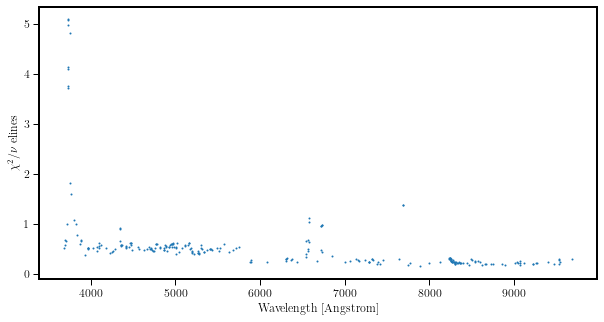

In [268]:
fig, ax = plt.subplots(1,figsize=(10, 5))
ax.scatter(tab_el_chi['wave'],tab_el_chi['X_sq'],s=1)
ax.set_xlabel('Wavelength [Angstrom]')
ax.set_ylabel(r'$\chi^2/\nu$ elines')   

In [ ]:
expanded_array = np.tile(mask, (ny, 1))

In [229]:
#tab_sig_kms.colnames

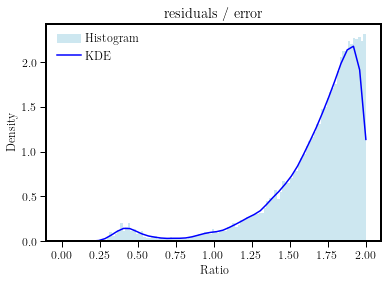

In [ ]:
error_check = 0
if (error_check == 1):
    from scipy.stats import gaussian_kde

    rat = error_map / rss_eflux_masked 
    # Define the range for the histogram
    range_min, range_max = 0, 2

    # Filter the data within the range
    filtered_rat = rat[(rat >= range_min) & (rat <= range_max)]

    # Plot a smooth histogram
    plt.hist(filtered_rat.flatten(), bins=100, density=True, alpha=0.6, color='lightblue', label='Histogram')

    # Add a KDE (Kernel Density Estimate) for smoothness
    kde = gaussian_kde(filtered_rat.flatten())
    x_vals = np.linspace(range_min, range_max, 50)
    plt.plot(x_vals, kde(x_vals), color='blue', label='KDE')

    # Add labels and legend
    plt.xlabel('Ratio')
    plt.ylabel('Density')
    plt.title('residuals / error')
    plt.legend()
    plt.show()

(array([12366.,     9.,     6.,     2.,     5.,     1.,     1.,     2.,     1.,     2.,     0.,     1.,     0.,     0.,     0.,     0.,     1.,     0.,     0.,     0.,     0.,     0.,     1.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     1.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     1.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     1.]),
 array([   0.0013,   37.9151,   75.8289,  113.7427,  151.6565,  189.5703,  227.4841,  265.3979,  303.3117,  341.2255,  379.1393,  417.0531,  454.9669,  492.88

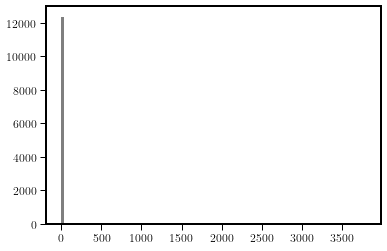

In [ ]:
#plt.hist(X_sq_st, bins=100, color='k', alpha=0.5)
#plt.scatter(X_sq_st, X_sq_st_np, s=1, c='k', alpha=0.5)
#plt.imshow(X_sq_st_np, origin='lower', aspect='auto', cmap='jet',vmin=-0.5, vmax=0.5)

In [269]:
##########################################################
#
# Storing the results 
##########################################################



hdu_info = fits.BinTableHDU(tab_info,name='INFO')


# Update header
hdr_0["dap_ver"] = "1.1.0.250507"

# Create HDUs
hdu_hdr_0 = fits.PrimaryHDU(header=hdr_0)
hdu_PT = fits.BinTableHDU(tab_PT, name="PT")
hdu_ELINES = fits.BinTableHDU(tab_elines, name="PM_ELINES")
hdu_FE_B = fits.BinTableHDU(tab_fe_B, name="NP_ELINES_B")
hdu_FE_R = fits.BinTableHDU(tab_fe_R, name="NP_ELINES_R")
hdu_FE_I = fits.BinTableHDU(tab_fe_I, name="NP_ELINES_I")
hdu_RSP = fits.BinTableHDU(tab_rsp, name="RSP")
hdu_COEFFS = fits.BinTableHDU(tab_coeffs, name="COEFFS")
hdu_KEL = fits.BinTableHDU(tab_kel, name="PM_KEL")
hdu_SIGMA = fits.BinTableHDU(tab_sig_kms, name="ELINES_SIGMA_CHI")
hdu_el_chi = fits.BinTableHDU(tab_el_chi, name="ELINES_CHI2_AVG")

# Output filename
#out_file_dap = f"{output_dir}/{config['label']}.dap.fits.gz"




# Write final output
fits.HDUList([
    hdu_hdr_0, hdu_PT, hdu_RSP, hdu_COEFFS, hdu_ELINES,
    hdu_FE_B, hdu_FE_R, hdu_FE_I, hdu_KEL, hdu_SIGMA, hdu_el_chi, hdu_info
]).writeto(out_file_dap, overwrite=True)

print(f"# Final DAP file written: {out_file_dap}")


# Final DAP file written: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/orion_10_nb.dap.fits.gz


In [43]:
#
# This is an itentionally erronous code to break the notebook
#
# STOP HERE
#
# The rest of the notebook is just for plotting and testing!
#
# print(tab_info[tab_info['param'] == 'nx_range']['value'])

tab_info.show_in_notebook()      


idx,param,value
0,output_path,/disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests
1,lvmdap_dir,/home/sanchez/sda2/code/python/lvmdap
2,rsp-file,/disk-a/sanchez/LVM/LVM/ver_231113/mstar-stlib-cl-108.fits.gz
3,sigma-inst,1
4,rsp-nl-file,/disk-a/sanchez/LVM/LVM/ver_231113/mstar-stlib-cl-12.fits.gz
5,input-fmt,rss
6,redshift,"[0.0, 5e-05, -0.0003, 0.0003]"
7,sigma,"[1, 5, 0.1, 30]"
8,AV,"[0, 0.3, 0.0, 2.5]"
9,emission-lines-file,../_legacy/emission_lines_long_list.LVM


In [44]:
tab_info

param,value
str24,str64
output_path,/disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests
lvmdap_dir,/home/sanchez/sda2/code/python/lvmdap
rsp-file,/disk-a/sanchez/LVM/LVM/ver_231113/mstar-stlib-cl-108.fits.gz
sigma-inst,1
rsp-nl-file,/disk-a/sanchez/LVM/LVM/ver_231113/mstar-stlib-cl-12.fits.gz
input-fmt,rss
redshift,"[0.0, 5e-05, -0.0003, 0.0003]"
sigma,"[1, 5, 0.1, 30]"
AV,"[0, 0.3, 0.0, 2.5]"


In [87]:
#
# PLOTTING THE RESULTS FROM THE FITTING
#

In [88]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits

from lvmdap.dap_tools import list_columns,read_DAP_file,map_plot_DAP
from matplotlib import use as mpl_use
#mpl_use('Agg')

%matplotlib inline
from matplotlib import rcParams as rc
rc.update({'font.size': 19,\
           'font.weight': 900,\
           'text.usetex': True,\
           'path.simplify'           :   True,\
           'xtick.labelsize' : 19,\
           'ytick.labelsize' : 19,\
#           'xtick.major.size' : 3.5,\
#           'ytick.major.size' : 3.5,\
           'axes.linewidth'  : 2.0,\
               # Increase the tick-mark lengths (defaults are 4 and 2)
           'xtick.major.size'        :   6,\
           'ytick.major.size'        :   6,\
           'xtick.minor.size'        :   3,\
           'ytick.minor.size'        :   3,\
           'xtick.major.width'       :   1,\
           'ytick.major.width'       :   1,\
           'lines.markeredgewidth'   :   1,\
           'legend.numpoints'        :   1,\
           'xtick.minor.width'       :   1,\
           'ytick.minor.width'       :   1,\
           'legend.frameon'          :   False,\
           'legend.handletextpad'    :   0.3,\
           'font.family'    :   'serif',\
           'mathtext.fontset'        :   'stix',\
           'axes.facecolor' : "w",\
           
          })


from my_utils import search_col

1.1.1


In [89]:
#
# Plottig the results
#
import matplotlib.colors as mpl_colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mpl_colors

class scatter():
    def __init__(self,x,y,ax,size=1,**kwargs):
        self.n = len(x)
        self.ax = ax
        self.ax.figure.canvas.draw()
        self.size_data=size
        self.size = size
        self.sc = ax.scatter(x,y,s=self.size,**kwargs)
        self._resize()
        self.cid = ax.figure.canvas.mpl_connect('draw_event', self._resize)

    def _resize(self,event=None):
        ppd=72./self.ax.figure.dpi
        trans = self.ax.transData.transform
        s =  ((trans((1,self.size_data))-trans((0,0)))*ppd)[1]
        if s != self.size:
            self.sc.set_sizes(s**2*np.ones(self.n))
            self.size = s
            self._redraw_later()

    def _redraw_later(self):
        self.timer = self.ax.figure.canvas.new_timer(interval=10)
        self.timer.single_shot = True
        self.timer.add_callback(lambda : self.ax.figure.canvas.draw_idle())
        self.timer.start()
        


def gamma_scale(flux,gamma):
    return (flux/np.abs(flux))*(np.abs(flux))**gamma

def gamma_scale_abs(flux,gamma):
    return (np.abs(flux))**gamma

def map_plot_DAP_ax(ax = None, tab_DAP = None ,line='flux_Halpha_6562.85', \
                 vmin=0, vmax=0, title=None, filename='junk',\
                 cmap='Spectral', fsize=5, figs_dir='.',fig_type=None,\
                 gamma=1.0, sf=1.0, tab_pt=None):

    rc.update({'font.size': 12,\
               'font.weight': 900,\
               'text.usetex': True,\
               'path.simplify'           :   True,\
               'xtick.labelsize' : 12,\
               'ytick.labelsize' : 12,\
               'axes.linewidth'  : 2.0,\
               'xtick.major.size'        :   6,\
               'ytick.major.size'        :   6,\
               'xtick.minor.size'        :   3,\
               'ytick.minor.size'        :   3,\
               'xtick.major.width'       :   1,\
               'ytick.major.width'       :   1,\
               'lines.markeredgewidth'   :   1,\
               'legend.numpoints'        :   1,\
               'xtick.minor.width'       :   1,\
               'ytick.minor.width'       :   1,\
               'legend.frameon'          :   False,\
               'legend.handletextpad'    :   0.3,\
               'font.family'    :   'serif',\
               'mathtext.fontset'        :   'stix',\
               'axes.facecolor' : "w",\
               })
    
    X=tab_DAP['ra']
    Y=tab_DAP['dec']
    C=tab_DAP[line]    
    if (title== None):
        title=line.replace("_"," ")
        title=line.replace("_"," ")
    if (vmin==vmax):
        vmin=np.nanmin(C)
        vmax=np.nanmax(C)
    print(line,vmin,vmax)
    if (ax == None):
        fig,ax = plt.subplots(1,1,figsize=(fsize,fsize))
    norm=mpl_colors.PowerNorm(vmin=vmin,vmax=vmax,gamma=gamma)
    scat=scatter(X, Y, ax, size=sf*35.6/3600, c=C, cmap=cmap, norm=norm)
    ax.set_xlabel('Ra [deg]')#,fontsize=21)
    ax.set_ylabel('Dec [deg]')#,fontsize=21)
    xx = ax.get_xlim()
    ax.set_xlim(xx[1],xx[0])
    if (fig_type != None):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(scat.sc, cax=cax,label=fr'{title}')
    if (tab_pt != None):
        for tap_pt_now in tab_pt:
            ax.text(tab_pt['ra'],tab_pt['dec'],tab_pt['id'])

    if (fig_type != None):
        fig.tight_layout()
        fig.savefig(f'{figs_dir}/{filename}.{fig_type}')
        plt.close()




In [231]:
#
# Reading the DAP file
#

tab_DAP = tab_join(tab_DAP,tab_sig_kms,keys=['id'],join_type='left')

#tab_DAP = read_DAP_file(out_file_dap)

flux_Halpha_6562.85 0.2 200000
X_sq_Halpha_6562.85 0 50
96.55789410360363
134990.19853657344


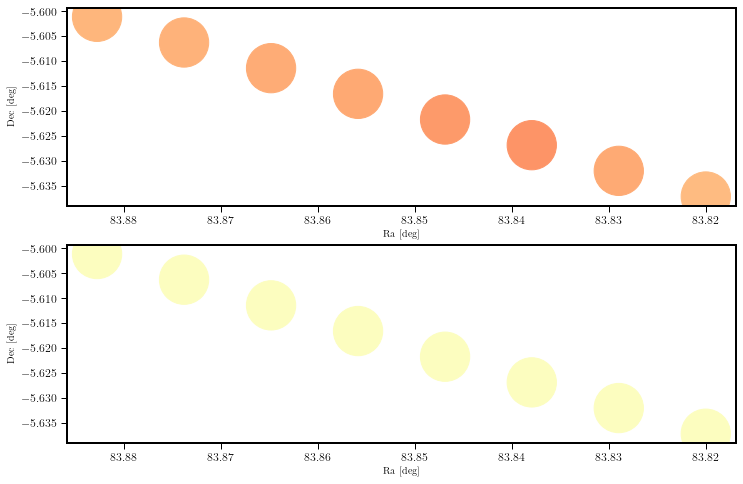

In [239]:
%matplotlib inline
#tab_DAP = tab_DAP_nb_test
#tab_DAP = tab_DAP_cm_test

fig,axes = plt.subplots(2, figsize=(12,8))
#fig,axes = plt.subplots(2,3, figsize=(7,4))

#axes[0][0].text(97.8,5.15,'NP v1.0.0')
#axes[1][0].text(97.8,5.15,'PM v1.0.0')


fsize = 4
map_plot_DAP_ax(ax=axes[0],tab_DAP=tab_DAP,line='flux_Halpha_6562.85', \
                 vmin=0.2, vmax=200000, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)
fsize = 4
map_plot_DAP_ax(ax=axes[1],tab_DAP=tab_DAP,line='X_sq_Halpha_6562.85', \
                 vmin=0, vmax=50, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)

print(np.nanmean(tab_DAP['X_sq_Halpha_6562.85']))
print(np.nanmean(tab_DAP['flux_Halpha_6562.85']))


In [91]:
#
# Orion dataset
#

#tab_DAP_cm=read_DAP_file('output_dap/junk_orion_CM.dap.fits.gz',verbose=True)
#tab_DAP_nb=read_DAP_file('output_dap/junk_orion_nb.dap.fits.gz',verbose=True)


In [92]:
#tab_DAP_cm=read_DAP_file('output_dap_v1.1.0_tests/dap-cm-00006109.dap.fits.gz',verbose=True)
#tab_DAP_nb=read_DAP_file('output_dap_v1.1.0_tests/dap-nb-00006109.dap.fits.gz',verbose=True)

#tab_DAP_nb_test=read_DAP_file('output_dap_v1.1.0_tests/dap-nb-00006109.dap.fits.gz',verbose=True)
#tab_DAP_nb_test=read_DAP_file('output_dap_v1.1.0_tests/dap-nb-OK-00006109.dap.fits.gz',verbose=True)
#tab_DAP_nb_test=read_DAP_file('output_dap_v1.1.0_tests/dap-nb-00006109_few.dap.fits.gz',verbose=True)

#tab_DAP_cm_test=read_DAP_file('output_dap_v1.1.0_tests/test-10.dap.fits.gz',verbose=True)
#output_dap_v1.1.0_tests/test-10.dap.fits.gz

disp_Halpha_6562.85 0.2 0.75
sigma_kms_Halpha_6562.85 0 50
disp_pek_6562.85 0.2 0.75
sigma_kms_pek_6562.85 0 50


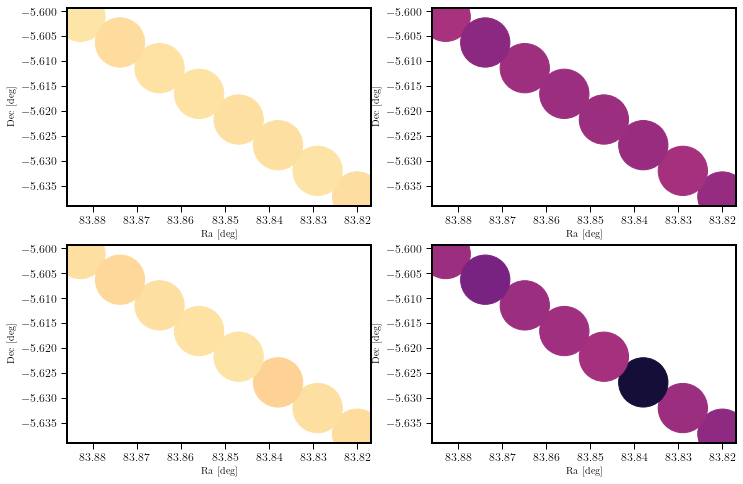

In [111]:
%matplotlib inline
#tab_DAP = tab_DAP_nb_test
#tab_DAP = tab_DAP_cm_test

fig,axes = plt.subplots(2,2, figsize=(12,8))
#fig,axes = plt.subplots(2,3, figsize=(7,4))

#axes[0][0].text(97.8,5.15,'NP v1.0.0')
#axes[1][0].text(97.8,5.15,'PM v1.0.0')


fsize = 4
map_plot_DAP_ax(ax=axes[0][0],tab_DAP=tab_DAP,line='disp_Halpha_6562.85', \
                 vmin=0.2, vmax=0.75, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)
fsize = 4
map_plot_DAP_ax(ax=axes[0][1],tab_DAP=tab_DAP,line='sigma_kms_Halpha_6562.85', \
                 vmin=0, vmax=50, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)

map_plot_DAP_ax(ax=axes[1][0],tab_DAP=tab_DAP,line='disp_pek_6562.85', \
                 vmin=0.2, vmax=0.75, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)
fsize = 4
map_plot_DAP_ax(ax=axes[1][1],tab_DAP=tab_DAP,line='sigma_kms_pek_6562.85', \
                 vmin=0, vmax=50, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)

flux_Halpha_6562.85 -100 100000
disp_Halpha_6562.85 0.2 0.75
vel_Halpha_6562.85 -5 5
flux_pe_6562.85 -100 100000
disp_pe_6562.85 0.2 0.75
vel_pe_6562.85 -5 5
flux_pek_6562.85 -100 100000
disp_pek_6562.85 0.2 0.75
vel_pek_6562.85 -5 5


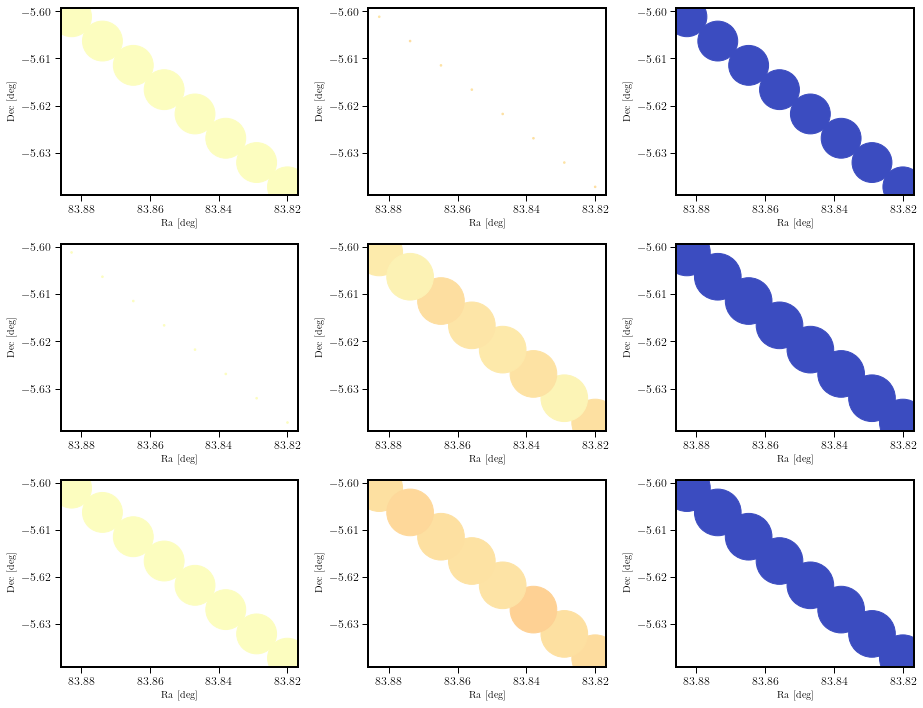

In [101]:
#tab_DAP['junk']=1.5*tab_DAP['flux_Halpha_6562.85']
%matplotlib inline
#tab_DAP = tab_DAP_nb_test
#tab_DAP = tab_DAP_cm_test

fig,axes = plt.subplots(3,3, figsize=(13,10))
#fig,axes = plt.subplots(2,3, figsize=(7,4))

#axes[0][0].text(97.8,5.15,'NP v1.0.0')
#axes[1][0].text(97.8,5.15,'PM v1.0.0')

fsize = 20
map_plot_DAP_ax(ax=axes[0][0],tab_DAP=tab_DAP,line='flux_Halpha_6562.85', \
                 vmin=-100, vmax=100000, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)

fsize = 10    
map_plot_DAP_ax(ax=axes[0][1],tab_DAP=tab_DAP,line='disp_Halpha_6562.85', \
                 vmin=0.2, vmax=0.75, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)

fsize = 10
map_plot_DAP_ax(ax=axes[0][2],tab_DAP = tab_DAP,line='vel_Halpha_6562.85', \
              vmin=-5, vmax=5, title=None, filename='junk',\
             cmap='coolwarm', fsize=fsize, figs_dir='figs',gamma=1,fig_type=None)

fsize = 10
map_plot_DAP_ax(ax=axes[1][0],tab_DAP=tab_DAP,line='flux_pe_6562.85', \
                 vmin=-100, vmax=100000, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)

fsize = 10
map_plot_DAP_ax(ax=axes[1][1],tab_DAP=tab_DAP,line='disp_pe_6562.85', \
                 vmin=0.2, vmax=0.75, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)
fsize = 10
map_plot_DAP_ax(ax=axes[1][2],tab_DAP = tab_DAP,line='vel_pe_6562.85', \
                 vmin=-5, vmax=5, title=None, filename='junk',\
             cmap='coolwarm', fsize=fsize, figs_dir='figs',gamma=1,fig_type=None)

fsize = 10
map_plot_DAP_ax(ax=axes[2][0],tab_DAP=tab_DAP,line='flux_pek_6562.85', \
                 vmin=-100, vmax=100000, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)

fsize = 10
map_plot_DAP_ax(ax=axes[2][1],tab_DAP=tab_DAP,line='disp_pek_6562.85', \
                 vmin=0.2, vmax=0.75, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)
fsize = 10
map_plot_DAP_ax(ax=axes[2][2],tab_DAP = tab_DAP,line='vel_pek_6562.85', \
                 vmin=-5, vmax=5, title=None, filename='junk',\
             cmap='coolwarm', fsize=fsize, figs_dir='figs',gamma=1,fig_type=None)



plt.tight_layout()


0.9915831294008894 0.9870520334237879 1.0131178156143394 vel: 1.0440224635009818


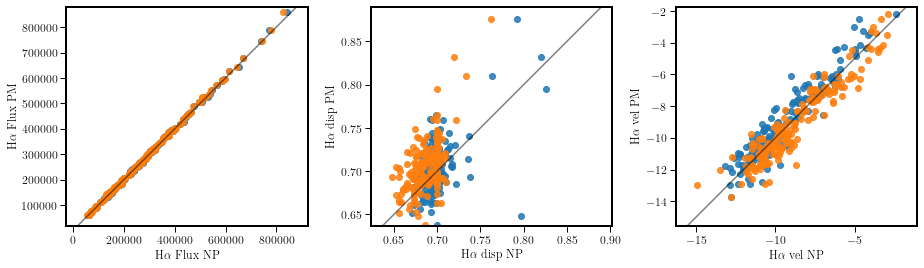

In [36]:
fig,axes = plt.subplots(1,3,figsize=(13,4.5))

#tab_DAP = tab_DAP_nb_test

mask_flux = tab_DAP['flux_Halpha_6562.85']>10000
rat_flux = np.median((tab_DAP['flux_Halpha_6562.85']/tab_DAP['flux_pe_6562.85'])[mask_flux])
rat_disp = np.median((tab_DAP['disp_Halpha_6562.85']/tab_DAP['disp_pe_6562.85'])[mask_flux])
rat_vel = np.median((tab_DAP['vel_Halpha_6562.85']/tab_DAP['vel_pe_6562.85'])[mask_flux])

print(rat_flux,rat_disp,1/rat_disp,'vel:',rat_vel)

ax = axes[0]
ax.scatter(tab_DAP['flux_Halpha_6562.85'],tab_DAP['flux_pe_6562.85'],alpha=0.85)
ax.scatter(tab_DAP['flux_pek_6562.85'],tab_DAP['flux_pe_6562.85'],alpha=0.85)
ax.set_xlabel(r'H$\alpha$ Flux NP')
ax.set_ylabel(r'H$\alpha$ Flux PM')
ax.set_aspect('equal', adjustable='box')
x_lim = ax.get_xlim()
ax.set_ylim(x_lim)
ax.plot(x_lim,x_lim,color='black',alpha=0.5)

ax.set_aspect('equal', 'box')
#ax.text(0,x_lim[1]*0.85,'v1.0.0')

ax = axes[1]
ax.scatter(tab_DAP['disp_Halpha_6562.85'],tab_DAP['disp_pe_6562.85'],alpha=0.85)
ax.scatter(tab_DAP['disp_pek_6562.85'],tab_DAP['disp_pe_6562.85'],alpha=0.85)
ax.set_xlabel(r'H$\alpha$ disp NP')
ax.set_ylabel(r'H$\alpha$ disp PM')
ax.set_aspect('equal', adjustable='box')
x_lim = ax.get_xlim()
ax.set_ylim(x_lim)
ax.plot(x_lim,x_lim,color='black',alpha=0.5)
ax.set_aspect('equal', 'box')

ax = axes[2]
ax.scatter(tab_DAP['vel_Halpha_6562.85'],tab_DAP['vel_pe_6562.85'],alpha=0.85)
ax.scatter(tab_DAP['vel_pek_6562.85'],tab_DAP['vel_pe_6562.85'],alpha=0.85)
ax.set_xlabel(r'H$\alpha$ vel NP')
ax.set_ylabel(r'H$\alpha$ vel PM')
ax.set_aspect('equal', adjustable='box')

#ax.set_xlim(-5,5)
x_lim = ax.get_xlim()
ax.set_ylim(x_lim)
ax.plot(x_lim,x_lim,color='black',alpha=0.5)
ax.set_aspect('equal', 'box')

plt.tight_layout()






<IPython.core.display.Javascript object>


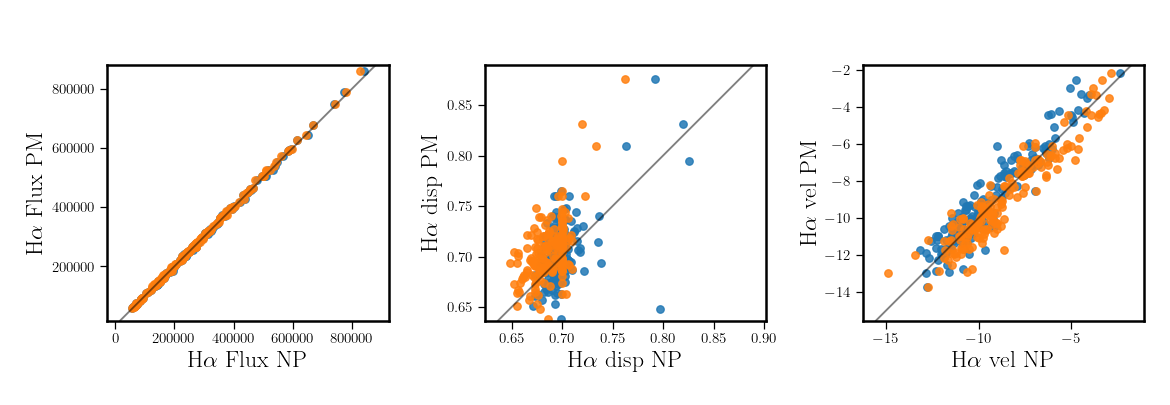

0.9915831294008894 0.9870520334237879 1.0131178156143394 vel: 1.0440224635009818


In [39]:

from scipy.stats import gaussian_kde

def scatter_den(x,y,cmap='viridis', ax=None):
        #Combine x and y into a 2D array
        xy = np.vstack([x, y])

        # Calculate point density
        kde = gaussian_kde(xy)
        density = kde(xy)
        
        # Normalize density for color and size
        norm_density = (density - density.min()) / (density.max() - density.min())
        size = 50 + norm_density * 200  # scale size between 50 and 250
        
        # Plot scatter with color and size based on density
        if (ax==None):
            fig,ax = plt.subplots(figsize=(5,5))
        ax.scatter(x, y, c=norm_density, s=size, cmap=cmap, edgecolors='k', alpha=0.7)




fig,axes = plt.subplots(1,3,figsize=(13,4.5))

#tab_DAP = tab_DAP_nb_test

mask_flux = tab_DAP['flux_Halpha_6562.85']>10000
rat_flux = np.median((tab_DAP['flux_Halpha_6562.85']/tab_DAP['flux_pe_6562.85'])[mask_flux])
rat_disp = np.median((tab_DAP['disp_Halpha_6562.85']/tab_DAP['disp_pe_6562.85'])[mask_flux])
rat_vel = np.median((tab_DAP['vel_Halpha_6562.85']/tab_DAP['vel_pe_6562.85'])[mask_flux])

print(rat_flux,rat_disp,1/rat_disp,'vel:',rat_vel)

ax = axes[0]



ax.scatter(tab_DAP['flux_Halpha_6562.85'],tab_DAP['flux_pe_6562.85'],alpha=0.85)
ax.scatter(tab_DAP['flux_pek_6562.85'],tab_DAP['flux_pe_6562.85'],alpha=0.85)
ax.set_xlabel(r'H$\alpha$ Flux NP')
ax.set_ylabel(r'H$\alpha$ Flux PM')
ax.set_aspect('equal', adjustable='box')
x_lim = ax.get_xlim()
ax.set_ylim(x_lim)
ax.plot(x_lim,x_lim,color='black',alpha=0.5)

ax.set_aspect('equal', 'box')
#ax.text(0,x_lim[1]*0.85,'v1.0.0')

ax = axes[1]
ax.scatter(tab_DAP['disp_Halpha_6562.85'],tab_DAP['disp_pe_6562.85'],alpha=0.85)
ax.scatter(tab_DAP['disp_pek_6562.85'],tab_DAP['disp_pe_6562.85'],alpha=0.85)
ax.set_xlabel(r'H$\alpha$ disp NP')
ax.set_ylabel(r'H$\alpha$ disp PM')
ax.set_aspect('equal', adjustable='box')
x_lim = ax.get_xlim()
ax.set_ylim(x_lim)
ax.plot(x_lim,x_lim,color='black',alpha=0.5)
ax.set_aspect('equal', 'box')

ax = axes[2]
ax.scatter(tab_DAP['vel_Halpha_6562.85'],tab_DAP['vel_pe_6562.85'],alpha=0.85)
ax.scatter(tab_DAP['vel_pek_6562.85'],tab_DAP['vel_pe_6562.85'],alpha=0.85)
ax.set_xlabel(r'H$\alpha$ vel NP')
ax.set_ylabel(r'H$\alpha$ vel PM')
ax.set_aspect('equal', adjustable='box')

#ax.set_xlim(-5,5)
x_lim = ax.get_xlim()
ax.set_ylim(x_lim)
ax.plot(x_lim,x_lim,color='black',alpha=0.5)
ax.set_aspect('equal', 'box')

plt.tight_layout()




